In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.distributions import chi2

In [2]:
import scipy

def gaussian(x, pos, wid, amp):
    y = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    return y

def biGauss(x, pos, wid, r, amp):
    mask = x < pos
    
    y_all = ([])
    for i in range(0, len(mask)):
    
        if mask[i] == True:
            m = 1
            nm = 0
        else:
            m = 0
            nm = 1
        if r != 0:
            y1 = gaussian(x[i],pos,r*wid/(r+1),amp)*m
            y2 = gaussian(x[i],pos,wid/(r+1),amp)*nm
            y = y1 + y2
        else:
            y = gaussian(x[i],pos,wid)*nm
        
        y_all = np.append(y_all, y)
    return y_all
    
def double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    b1 = biGauss(x, pos1, wid1, r1, amp1)
    b2 = biGauss(x, pos2, wid2, r2, amp2)
    b = np.append(b1, b2)
    return b1+b2

def log_likelihood_biGauss(theta, n, x):
    pos, wid, r, amp = theta
    model = biGauss(x, pos, wid, r, amp)
    L = np.log(scipy.special.factorial(n)) + model - (n*np.log(model))
    return np.sum(L)

def log_likelihood_doublePeak(theta, n, x):
    pos1, wid1, r1, amp1, pos2, wid2, r2, amp2 = theta
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    L = np.log(scipy.special.factorial(n)) + model - (n*np.log(model))
    return np.sum(L)
    
def likelihood_ratio_doublePeak(x, n, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    val = model - n + (n*np.log(n/model))
    #print(val)
    return np.sum(val)

def likelihood_ratio_biGauss(x, n, pos, wid, r, amp):
    model = biGauss(x, pos, wid, r, amp)
    val = model - n + (n*np.log(n/model))
    #print(val)
    return np.sum(val)



loaded geometry
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(17, 4, array([2.62726023e+07, 1.00000000e+01, 1.00000000e-01, 1.50000000e+02]))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


1.7804689407348633
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(47, 4, array([3.3302768e+07, 1.0000000e+01, 1.0000000e-01, 3.9000000e+01]))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/icecube.opensciencegrid.or

43.82333040982485
P-VAL CALCULATED
LOG LIKELIHOOD
(55, 4, array([3.33027125e+07, 1.00000000e+01, 1.00000000e-01, 1.40000000e+01]))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log
/cvmfs/ic

-4896.0529717206955
P-VAL CALCULATED
LOG LIKELIHOOD
(13, 4, array([3.33024776e+07, 1.00000000e+01, 1.00000000e-01, 6.30000000e+02]))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in double_scalars


6.179854035377502
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(13, 4, array([3.04764389e+07, 1.00000000e+01, 1.00000000e-01, 7.74000000e+02]))
7.257111009210348
P-VAL CALCULATED
LOG LIKELIHOOD
(28, 4, array([3.0476378e+07, 1.0000000e+01, 1.0000000e-01, 5.0000000e+01]))
6.180488932877779
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(12, 4, array([4.57257495e+06, 1.00000000e+01, 1.00000000e-01, 3.08000000e+02]))
5.660640196874738
P-VAL CALCULATED
LOG LIKELIHOOD
(19, 4, array([4.5725064e+06, 1.0000000e+01, 1.0000000e-01, 1.3900000e+02]))
0.6896873358637094
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(14, 4, array([1.61932376e+04, 1.00000000e+01, 1.00000000e-01, 7.50000000e+02]))
7.522936762245081
P-VAL CALCULATED
('frame num - ', 

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


7.2343738451600075
P-VAL CALCULATED
('frame num - ', 1)
LOG LIKELIHOOD
(13, 4, array([7.66659951e+04, 1.00000000e+01, 1.00000000e-01, 4.20000000e+02]))
7.007325756479986
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(37, 4, array([1.06902256e+04, 1.00000000e+01, 1.00000000e-01, 3.50000000e+01]))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


6.044035397479092
P-VAL CALCULATED
LOG LIKELIHOOD
(22, 4, array([1.07673626e+04, 1.00000000e+01, 1.00000000e-01, 9.30000000e+01]))
-188.4569434100904
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(29, 4, array([3.88895867e+04, 1.00000000e+01, 1.00000000e-01, 6.60000000e+01]))
9.948637483539642
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:2466: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in divide
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in divide


1816.8352992680884
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(41, 4, array([9.82005059e+03, 1.00000000e+01, 1.00000000e-01, 3.00000000e+01]))
10464.708153460539
P-VAL CALCULATED
LOG LIKELIHOOD
(29, 4, array([9.8876902e+03, 1.0000000e+01, 1.0000000e-01, 2.8400000e+02]))
12.539681791959083
P-VAL CALCULATED
LOG LIKELIHOOD
(32, 4, array([1.00509645e+04, 1.00000000e+01, 1.00000000e-01, 5.90000000e+01]))
-0.3152146566826559
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num

7.285083233458863
P-VAL CALCULATED
LOG LIKELIHOOD
(47, 4, array([3.35330642e+04, 1.00000000e+01, 1.00000000e-01, 5.00000000e+00]))
40.432427718864346
P-VAL CALCULATED
LOG LIKELIHOOD
(54, 4, array([3.36709115e+04, 1.00000000e+01, 1.00000000e-01, 2.10000000e+01]))
29.104915761701704
P-VAL CALCULATED
LOG LIKELIHOOD
(25, 4, array([3.38472133e+04, 1.00000000e+01, 1.00000000e-01, 1.38000000e+02]))
-556.829990111306
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(13, 4, array([3.05536836e+04, 1.00000000e+01, 1.00000000e-01, 6.04000000e+02]))
6.1991537397989305
P-VAL CALCULATED
('frame num - ', 1)
LOG LIKELIHOOD
(24, 4, array([1.02243854e+04, 1.00000000e+01, 1.00000000e-01, 8.40000000e+01]))
1.45704628364183
P-VAL

-430.8172679170966
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(13, 4, array([8.52398122e+04, 1.00000000e+01, 1.00000000e-01, 1.26000000e+02]))
3.639708941045683
P-VAL CALCULATED
LOG LIKELIHOOD
(32, 4, array([8.49137143e+04, 1.00000000e+01, 1.00000000e-01, 1.54000000e+02]))
3.828955672477605
P-VAL CALCULATED
LOG LIKELIHOOD
(27, 4, array([8.49906584e+04, 1.00000000e+01, 1.00000000e-01, 4.50000000e+01]))
4.432401235782891
P-VAL CALCULATED
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
('frame num - ', 1)
LOG LIKELIHOOD
(21, 4, array([3.50320105e+07, 1.00000000e+01, 1.00000000e-01, 7.80000000e+01]))
0.5425391048192

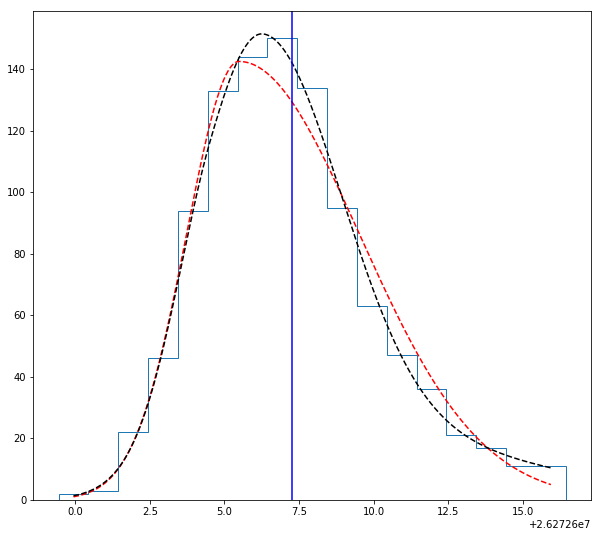

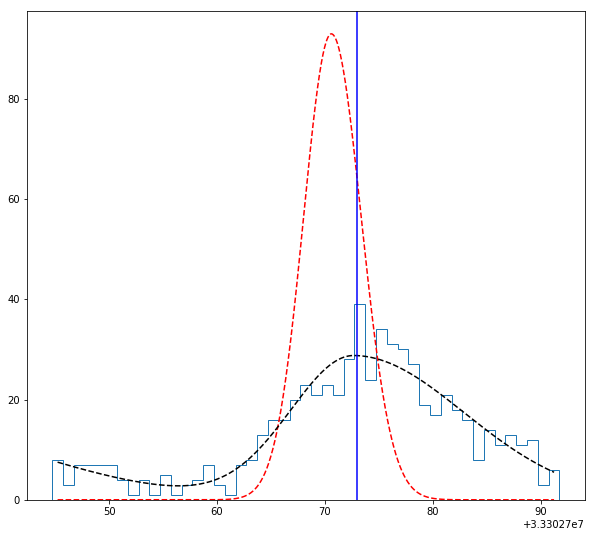

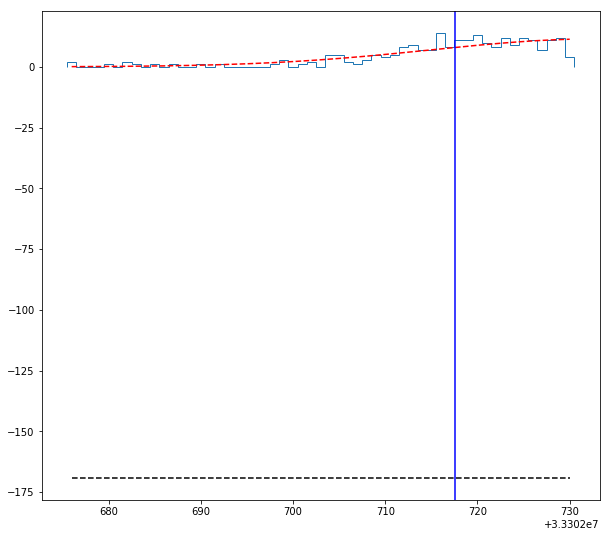

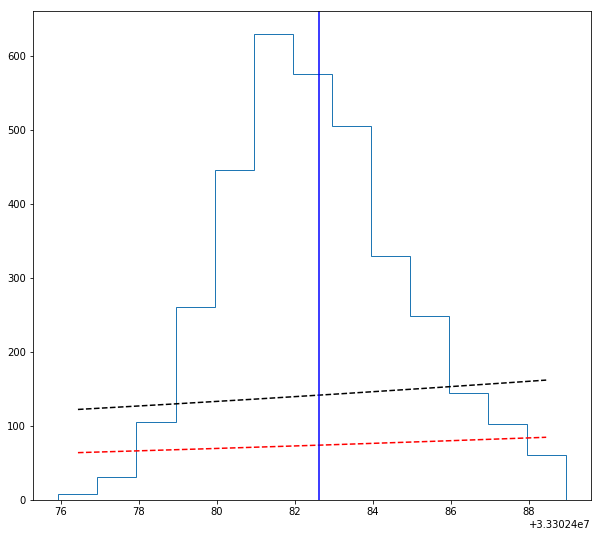

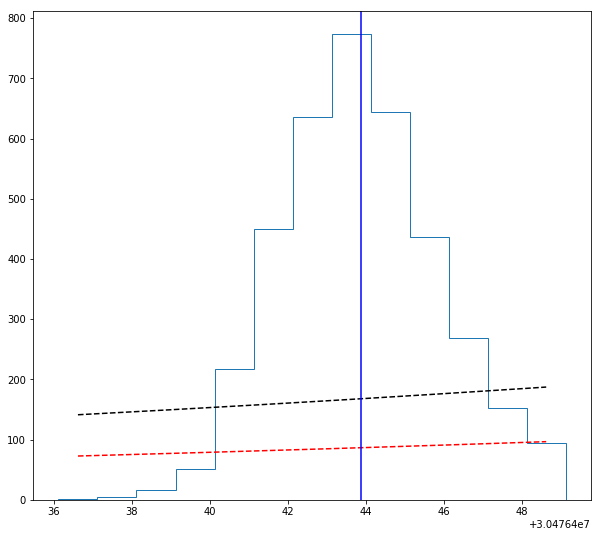

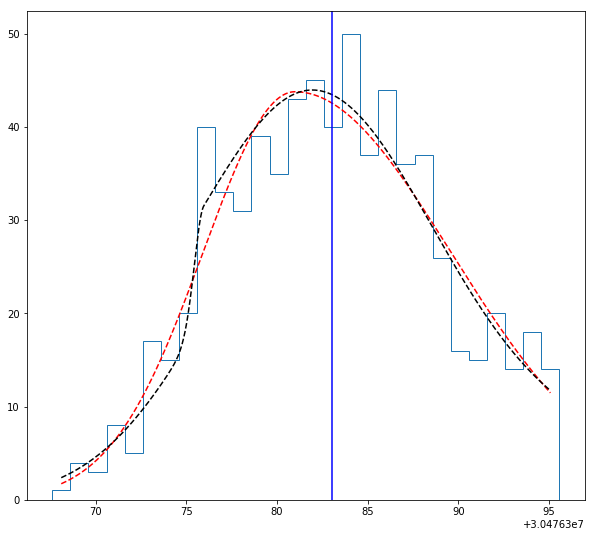

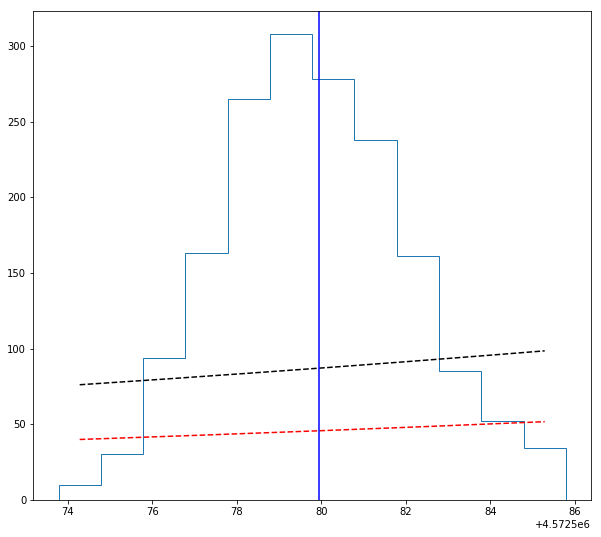

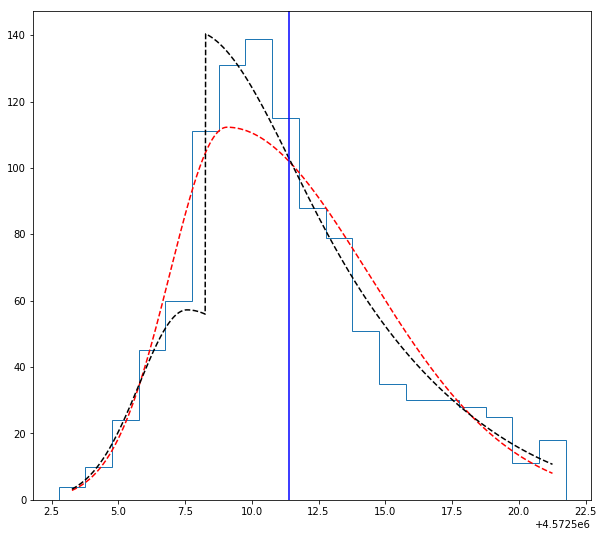

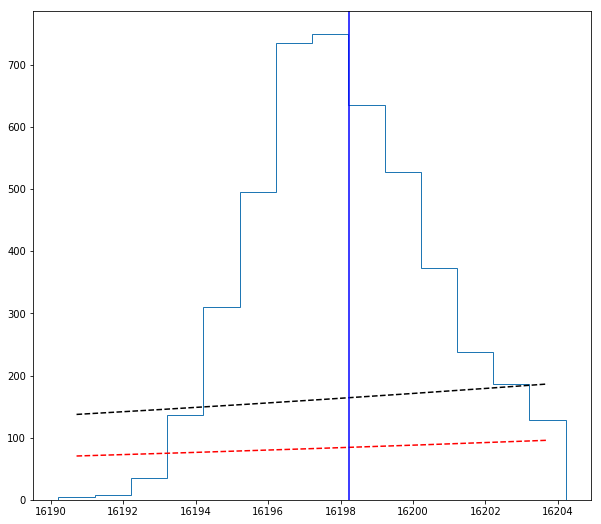

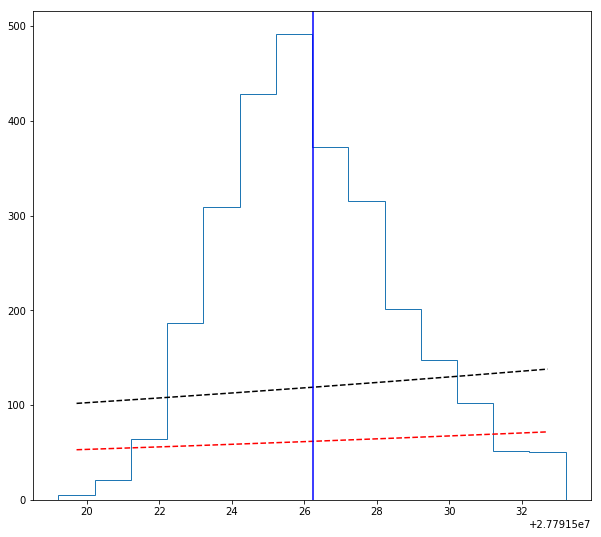

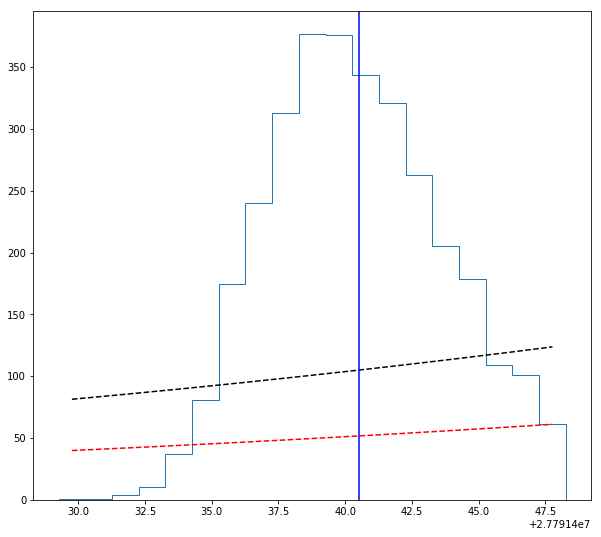

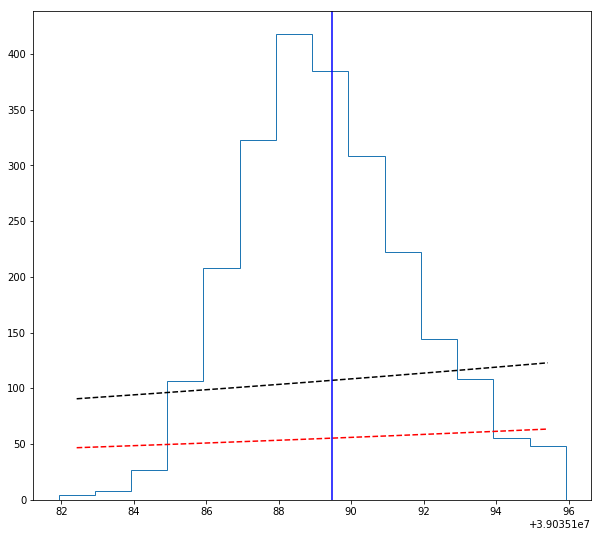

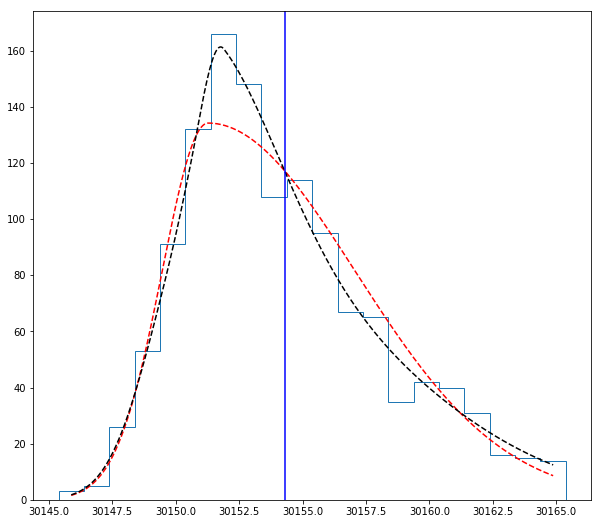

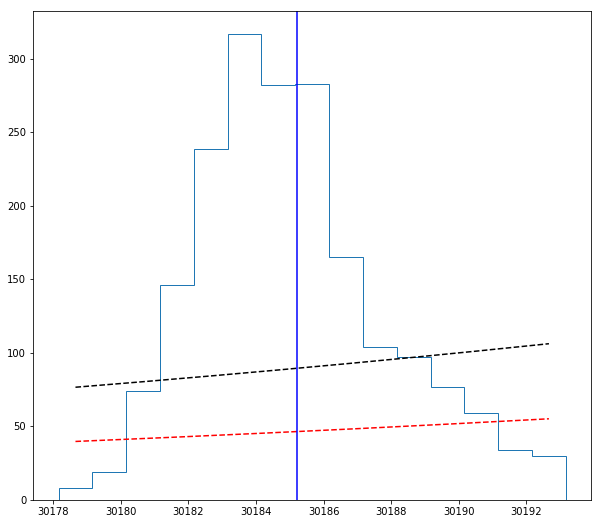

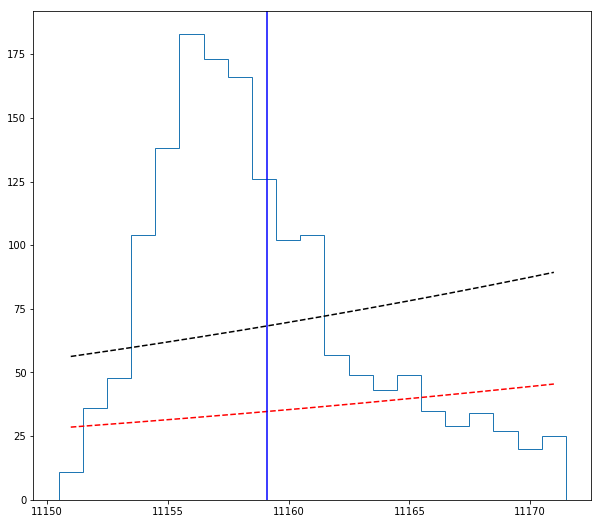

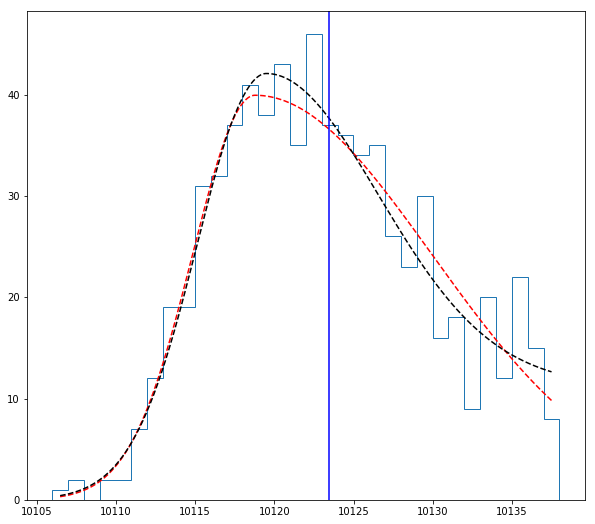

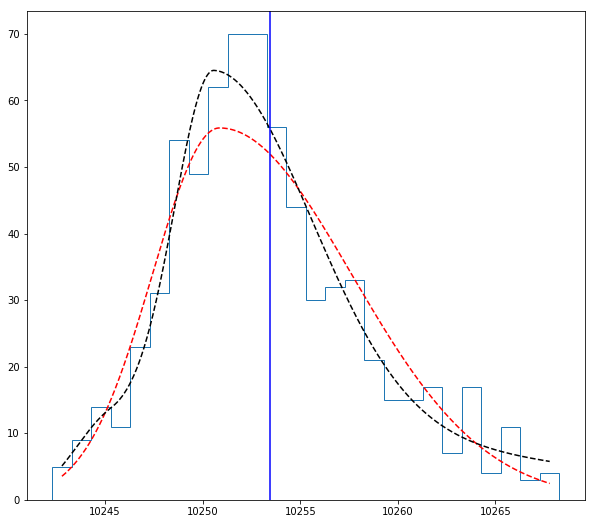

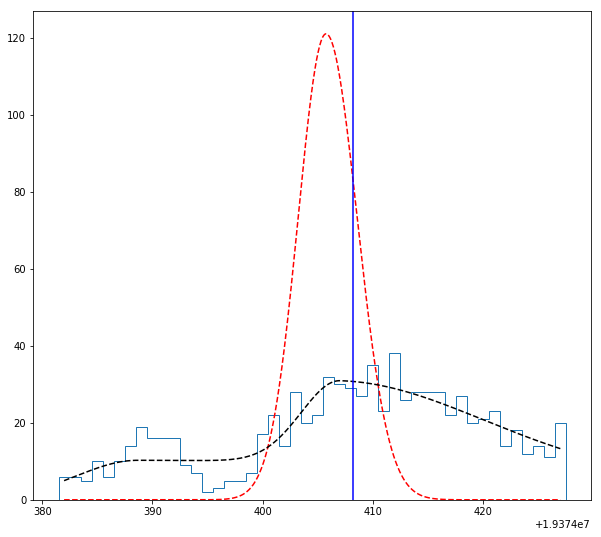

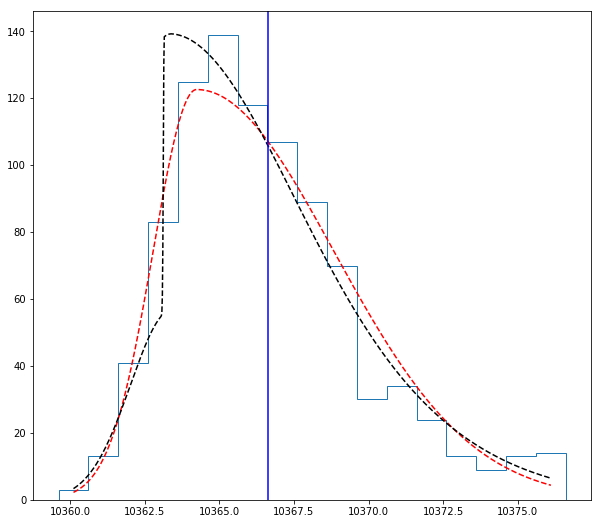

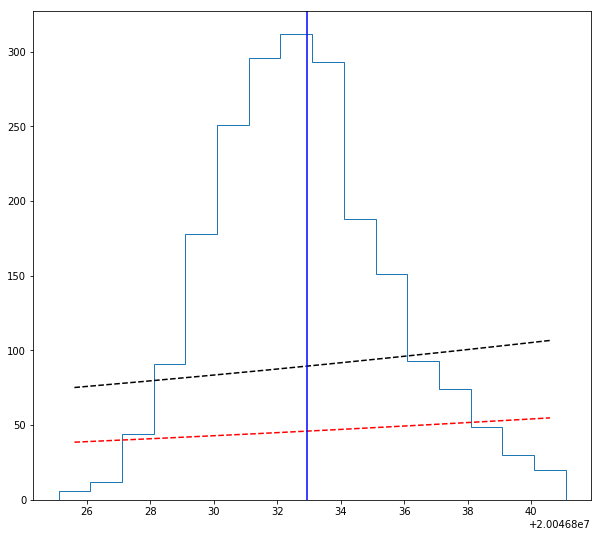

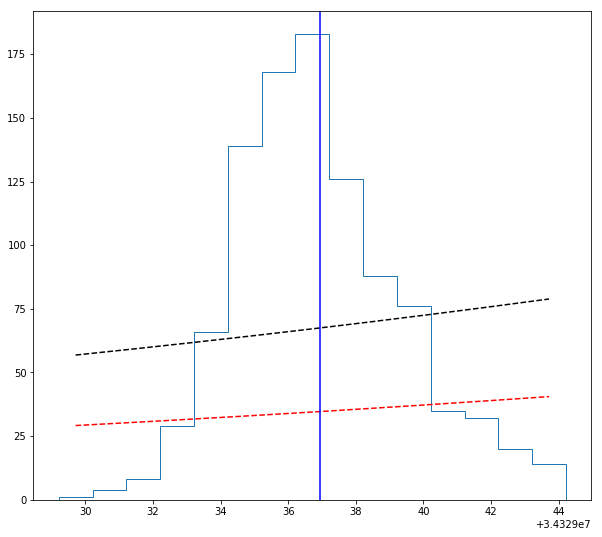

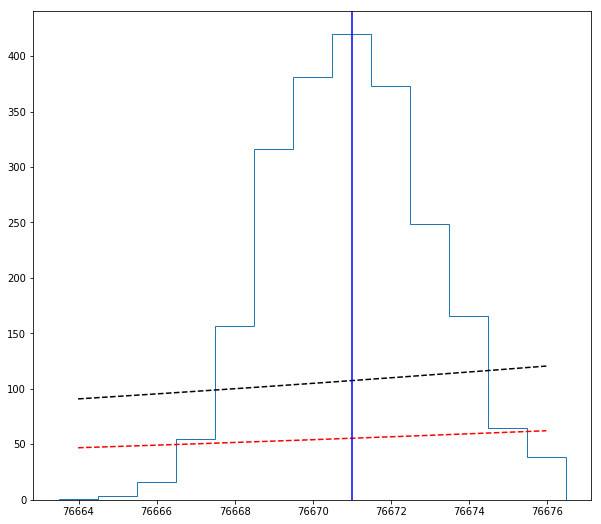

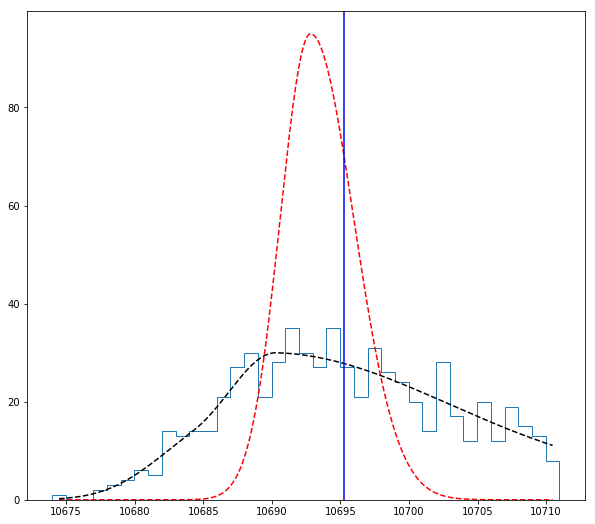

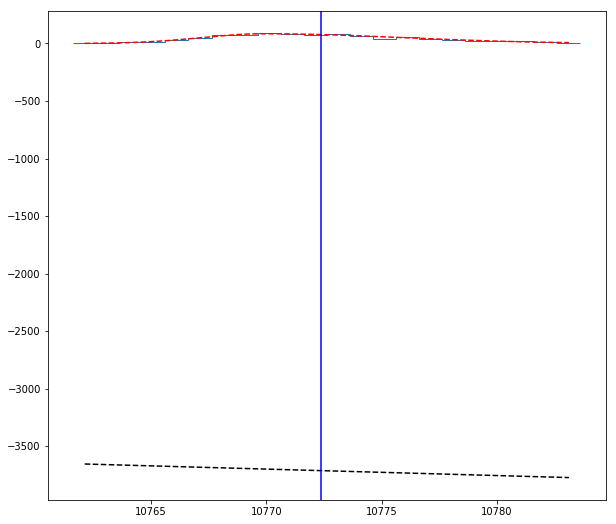

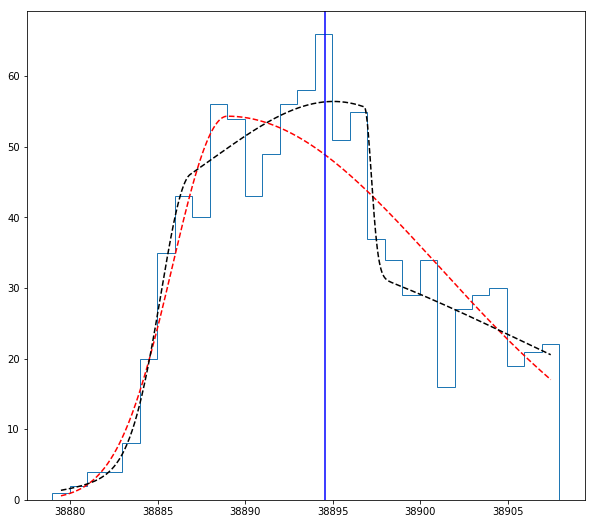

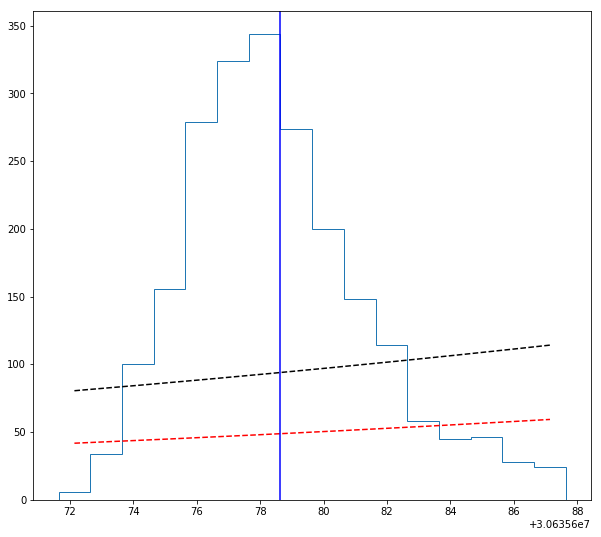

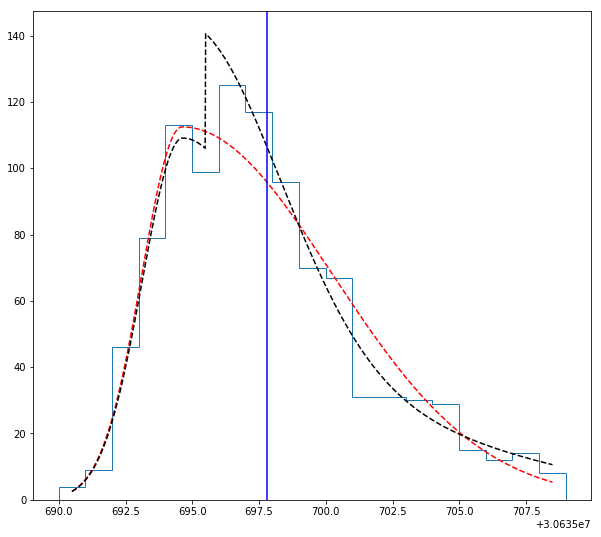

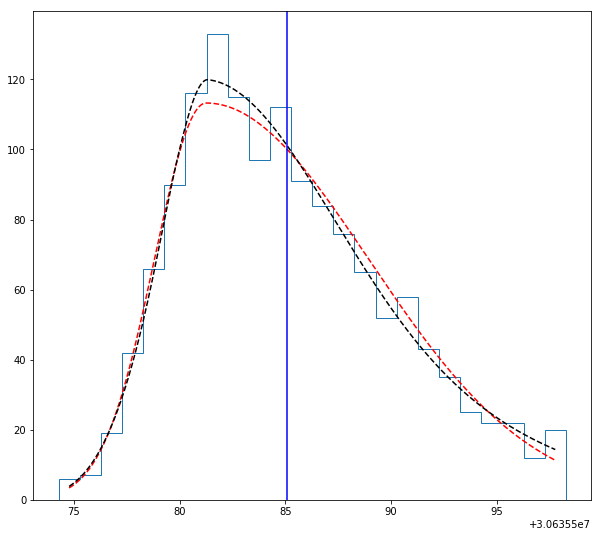

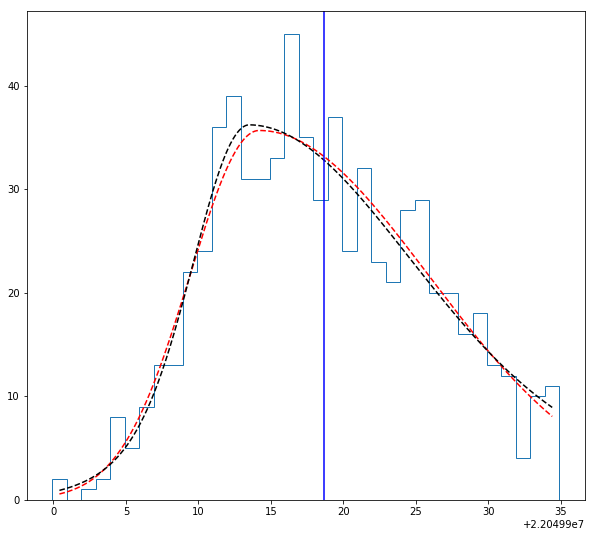

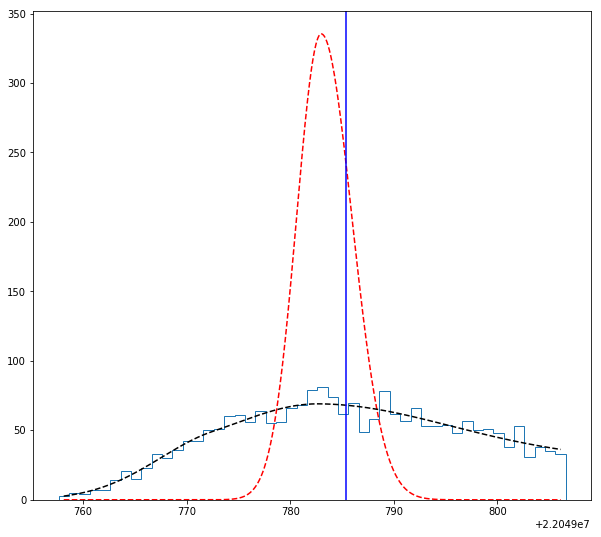

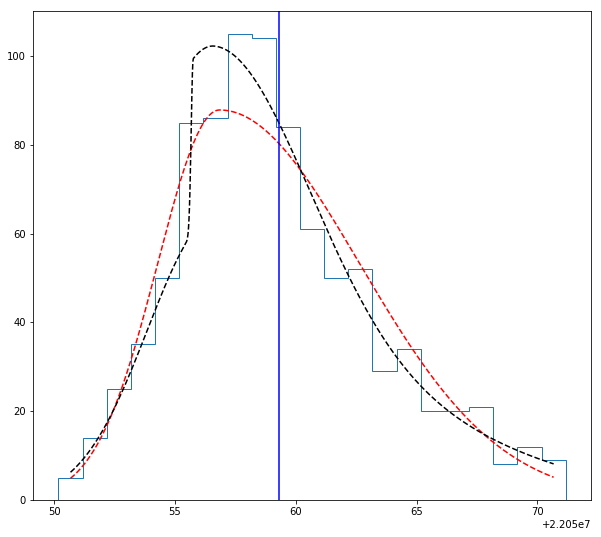

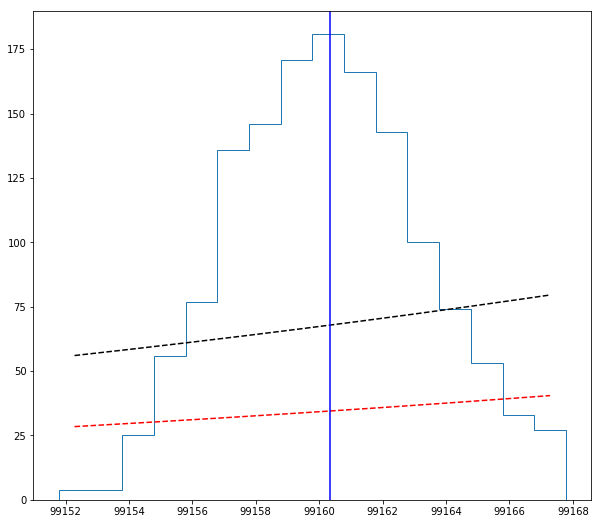

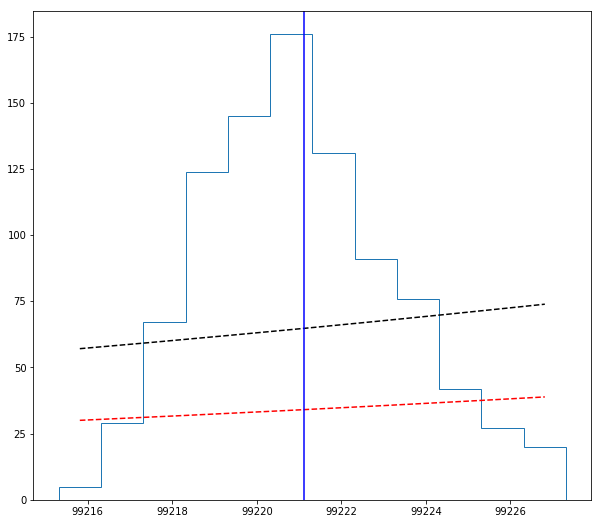

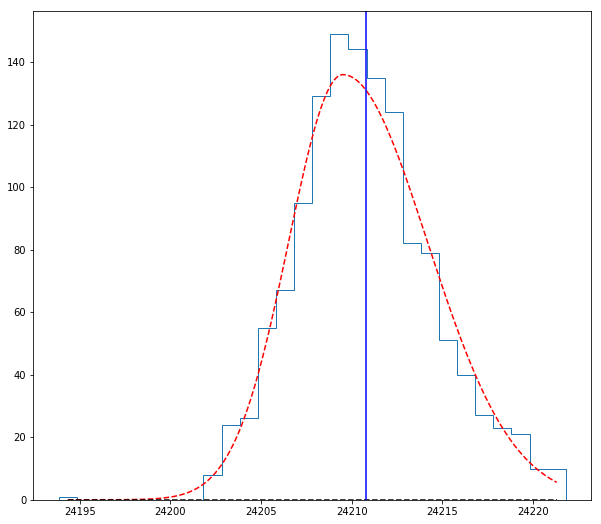

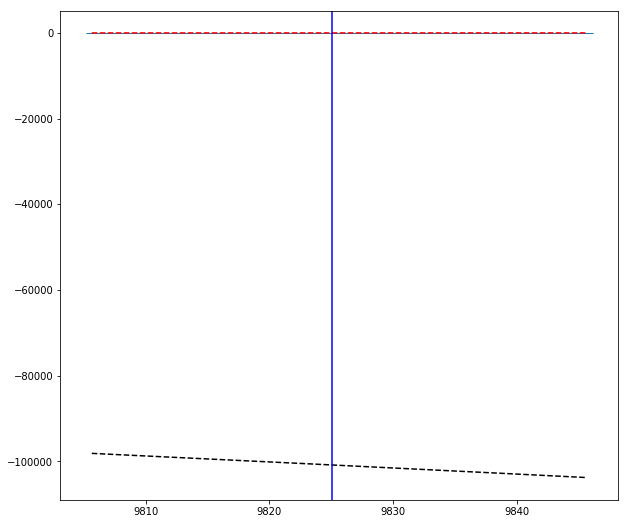

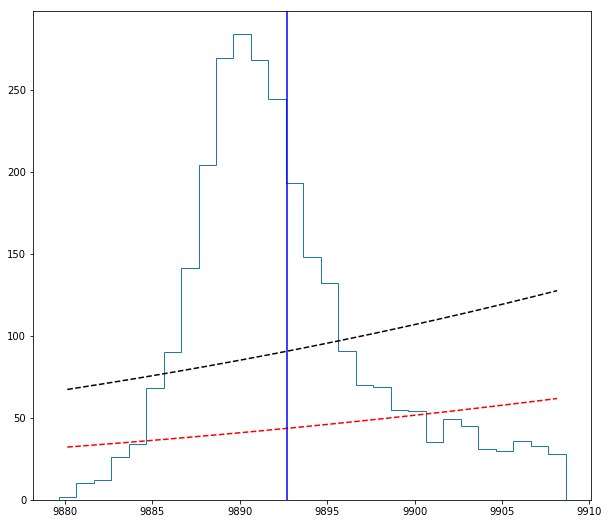

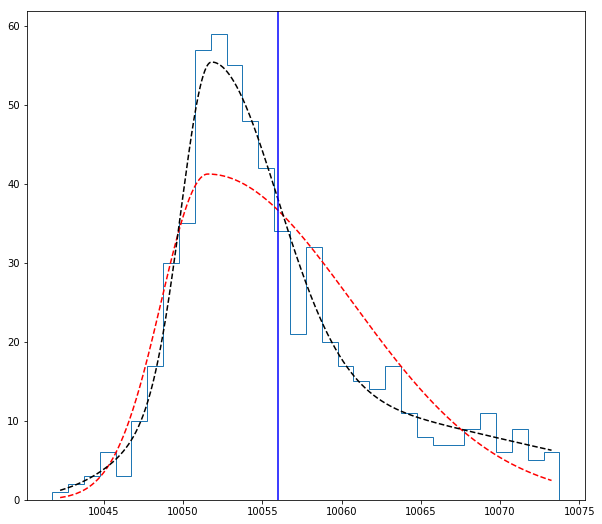

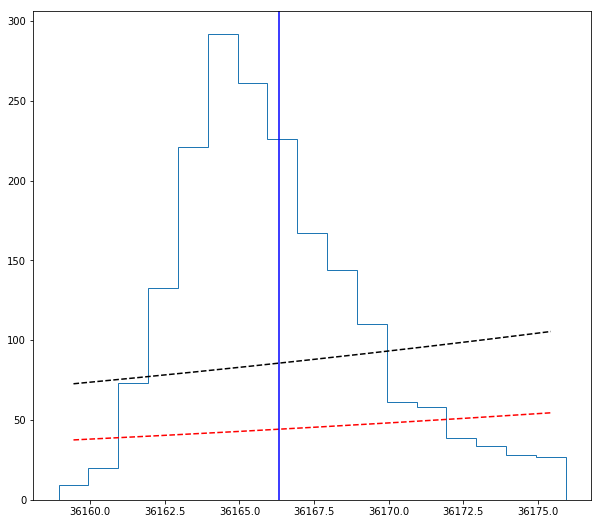

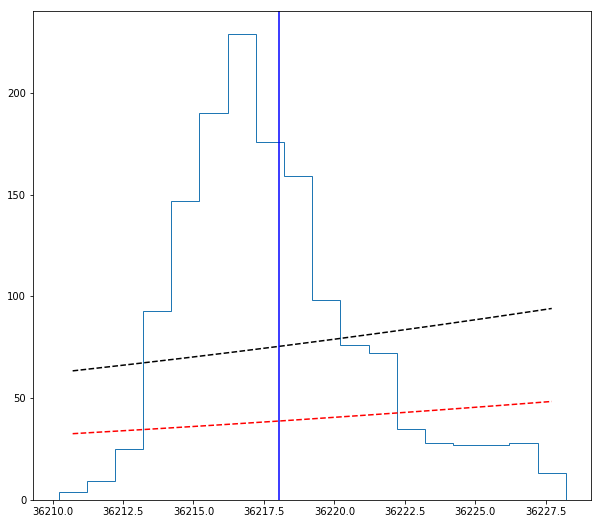

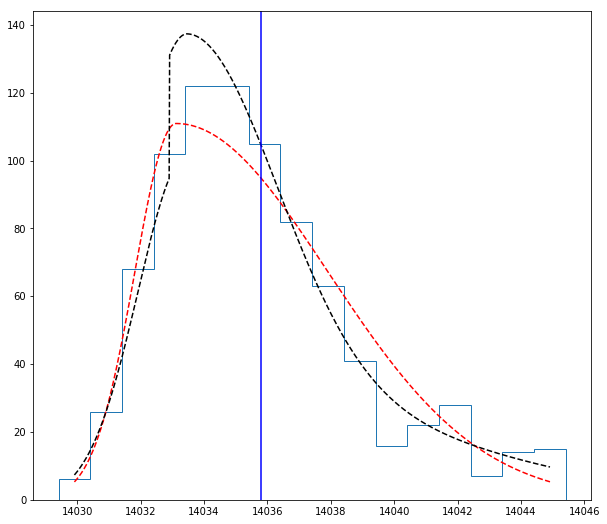

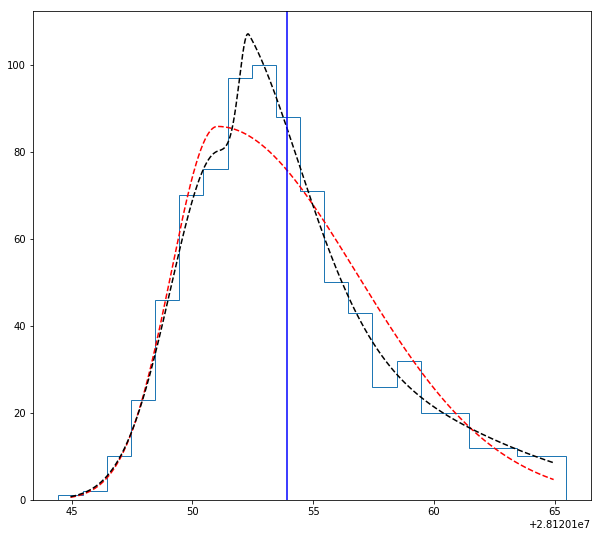

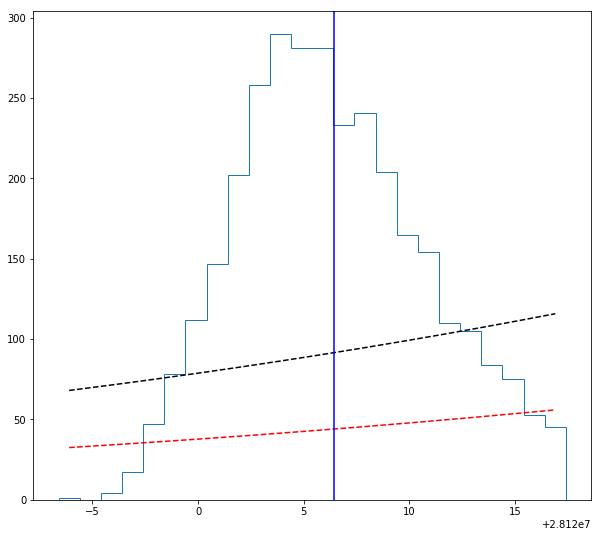

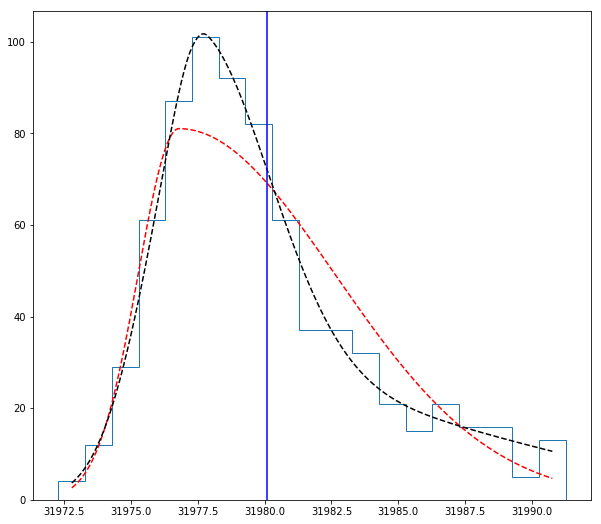

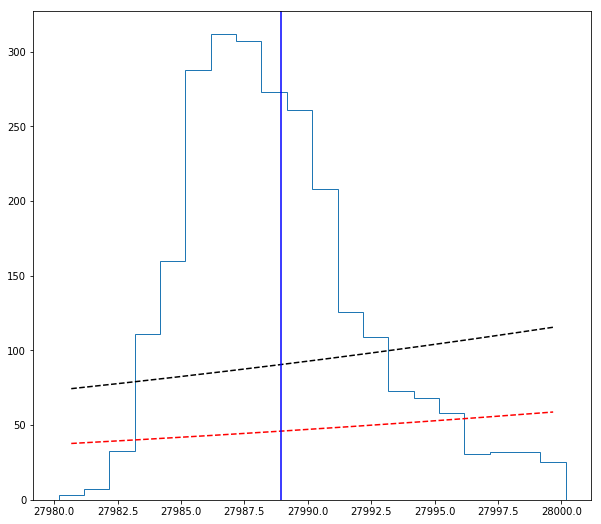

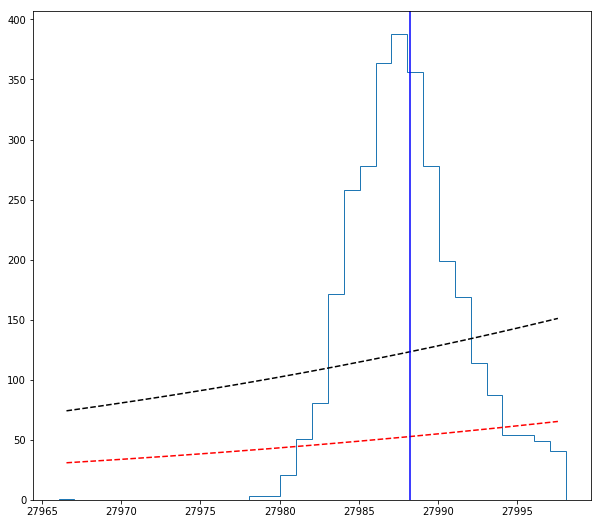

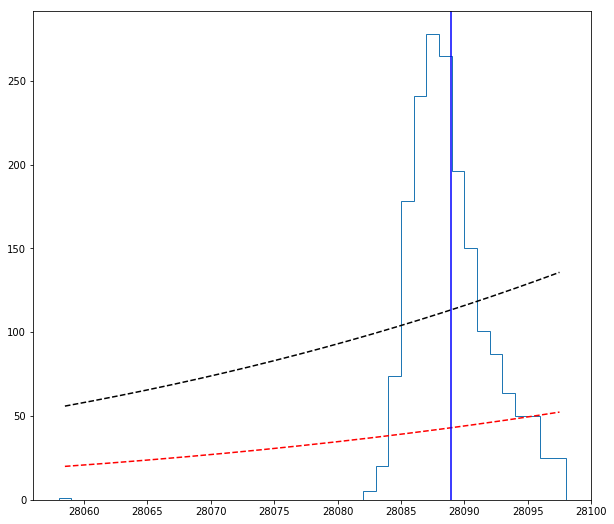

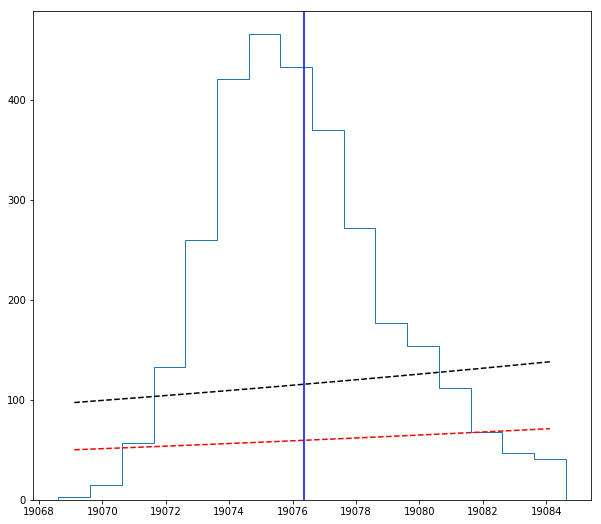

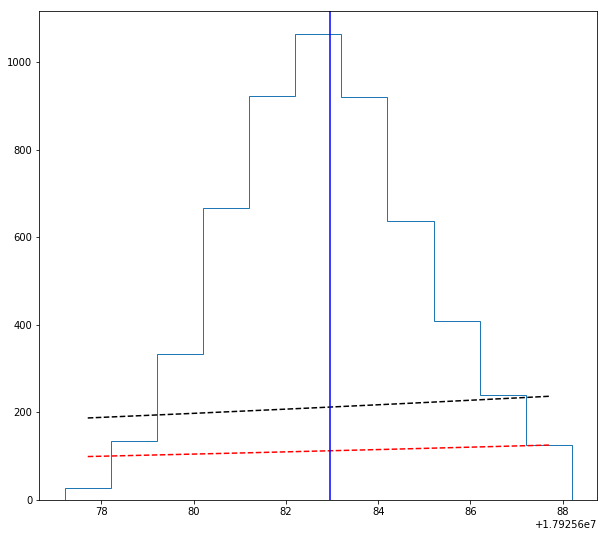

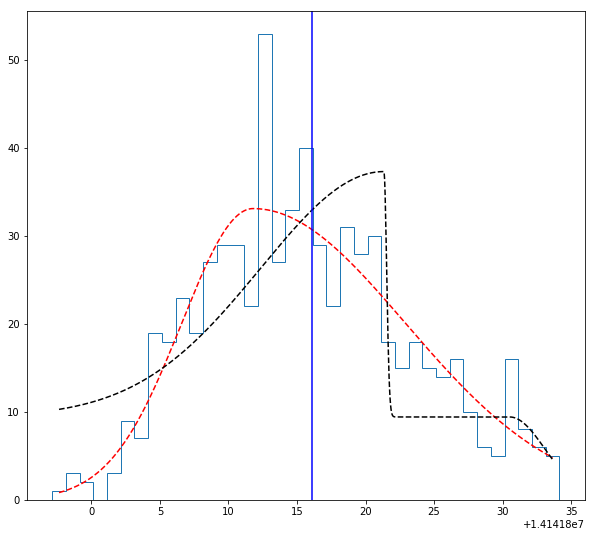

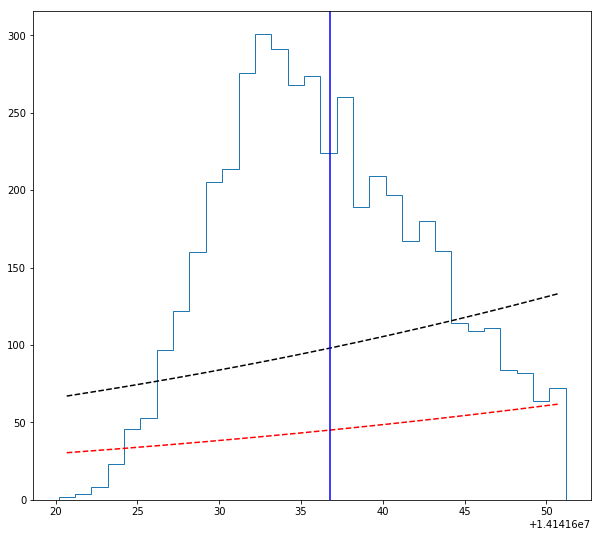

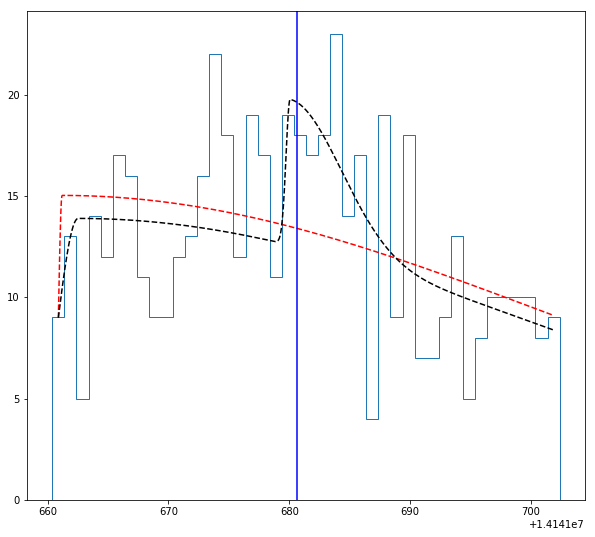

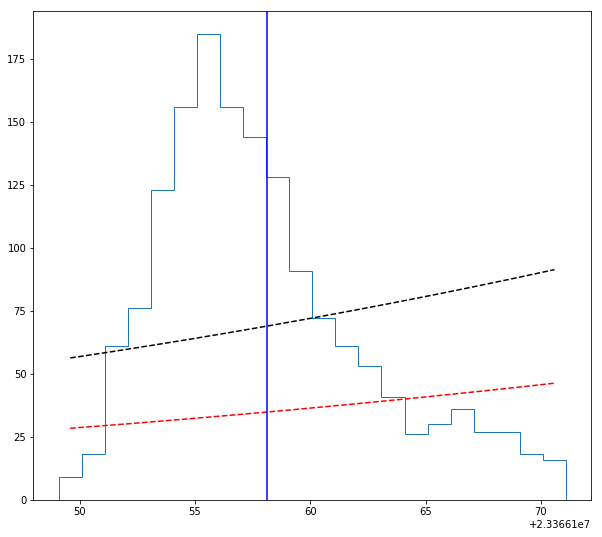

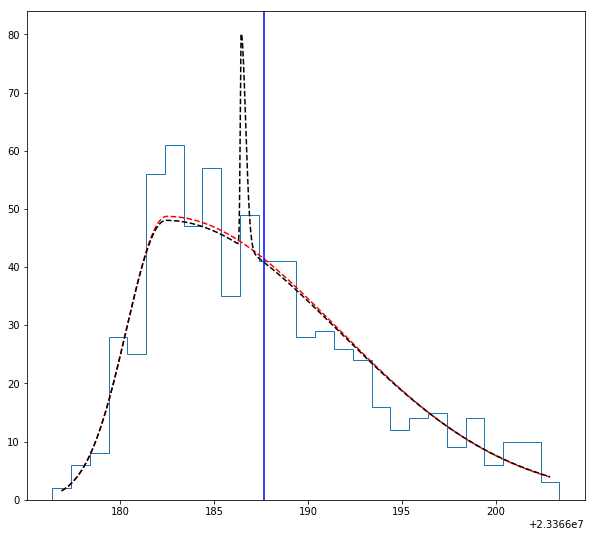

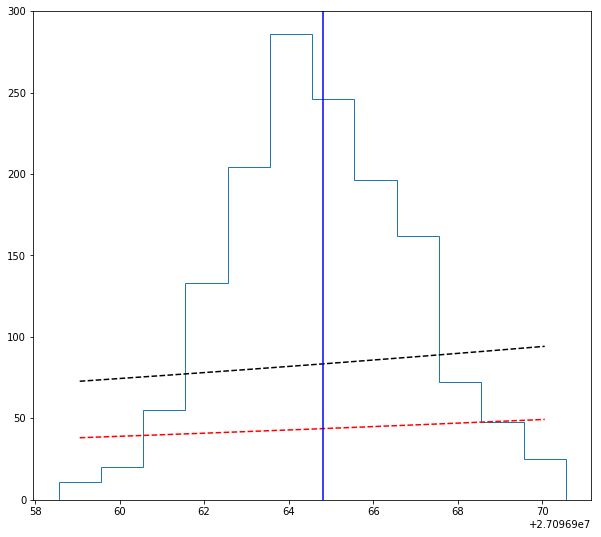

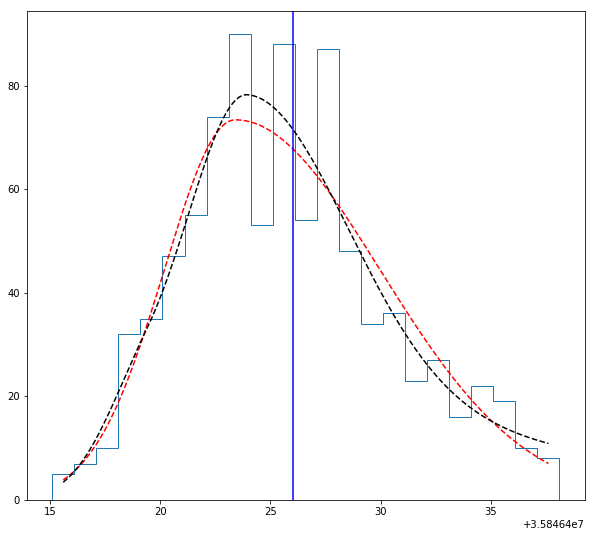

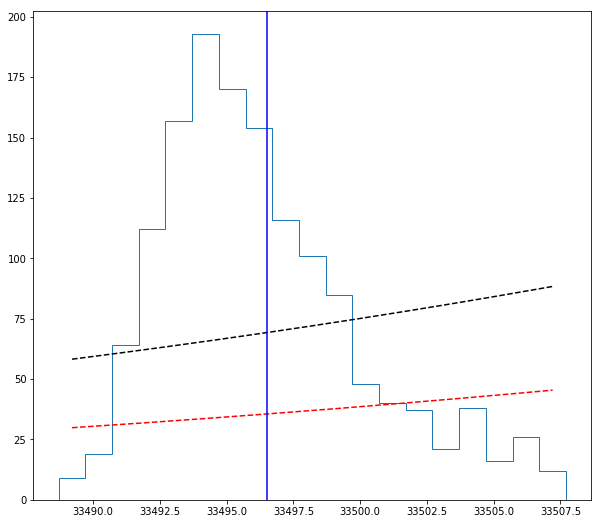

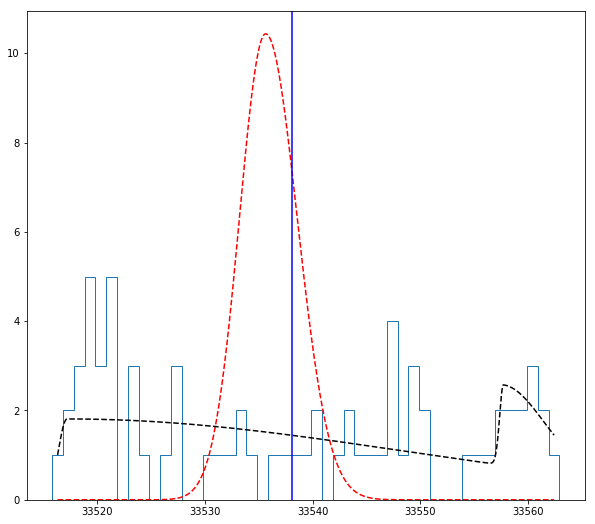

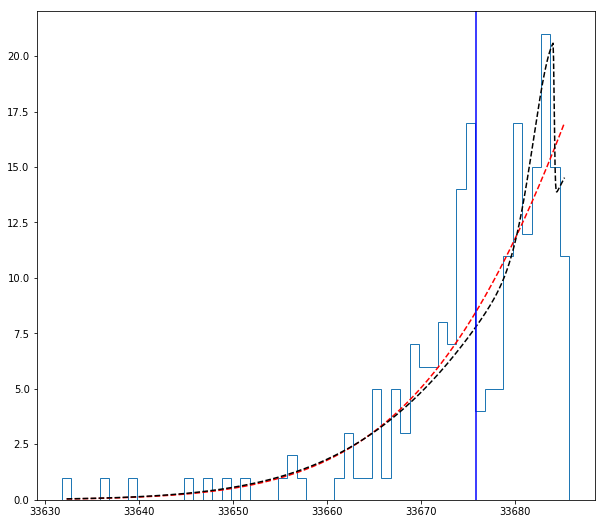

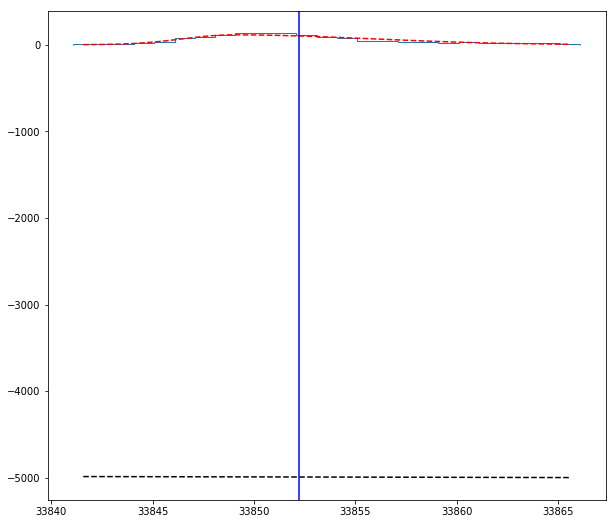

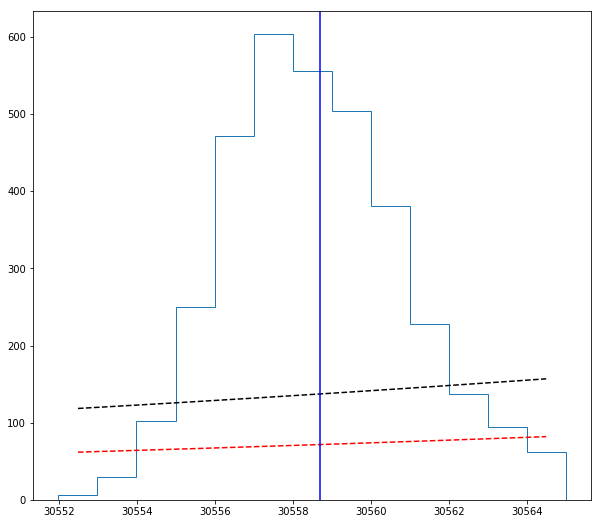

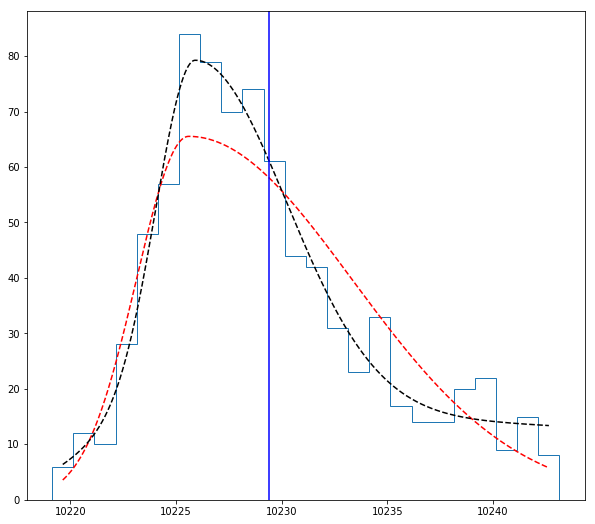

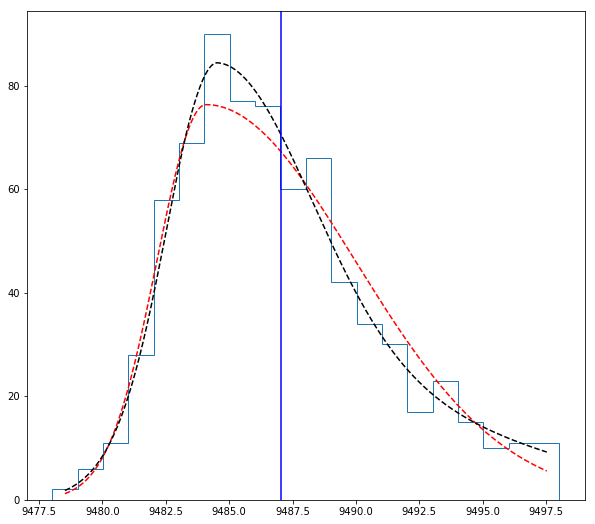

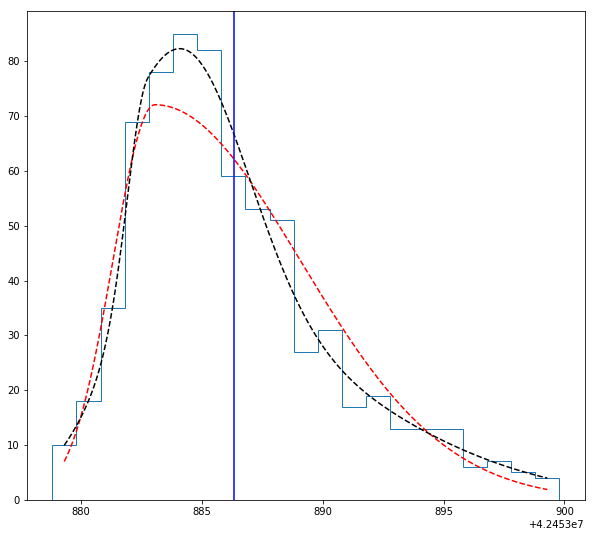

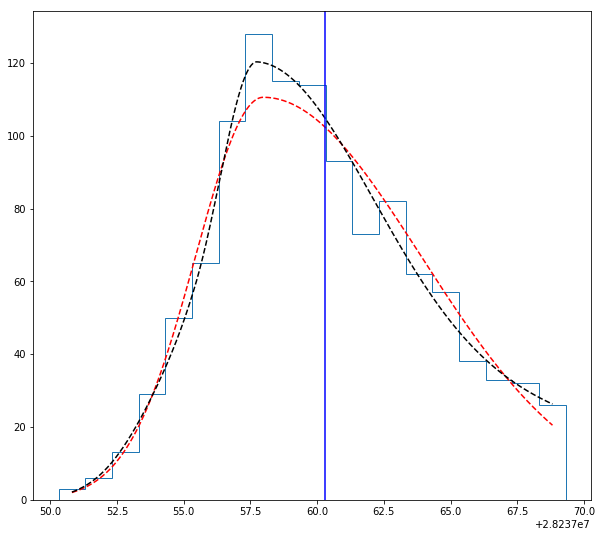

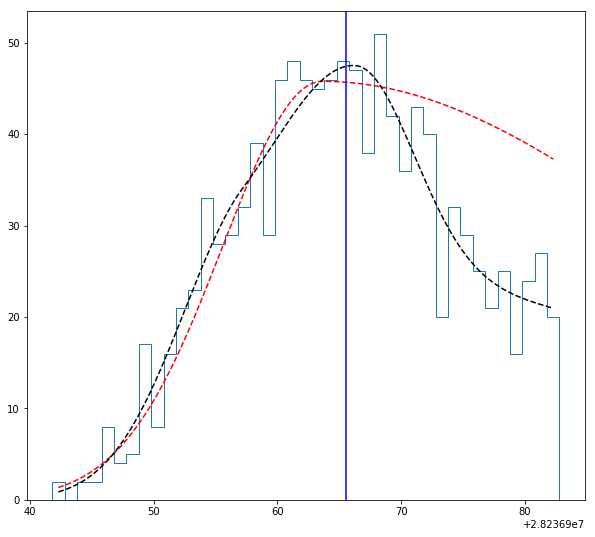

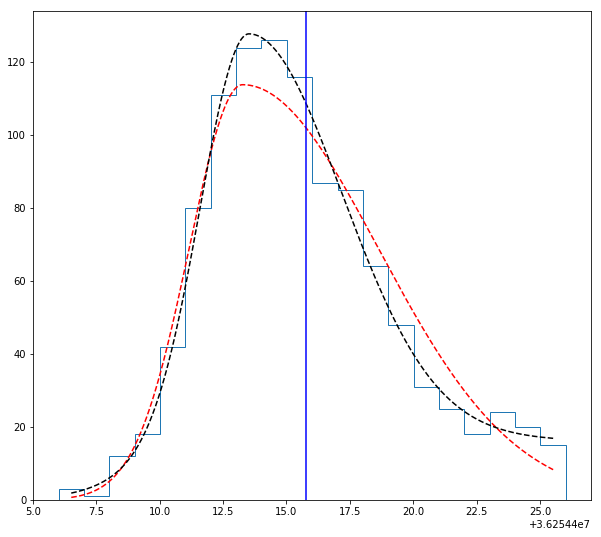

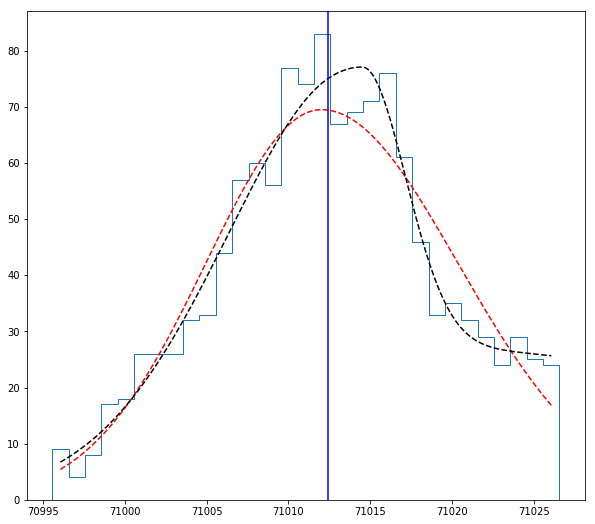

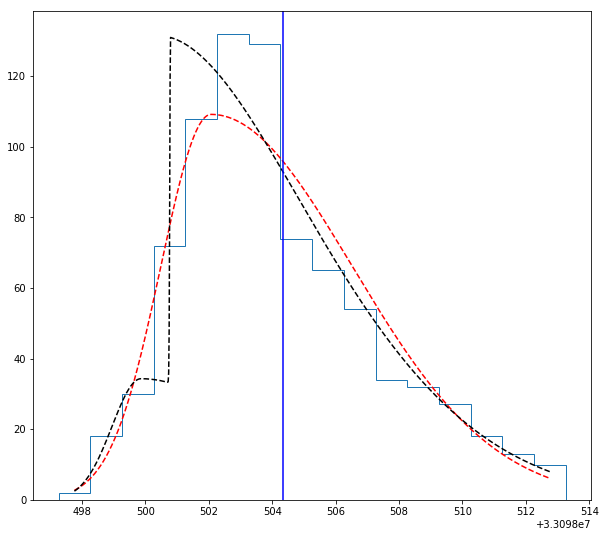

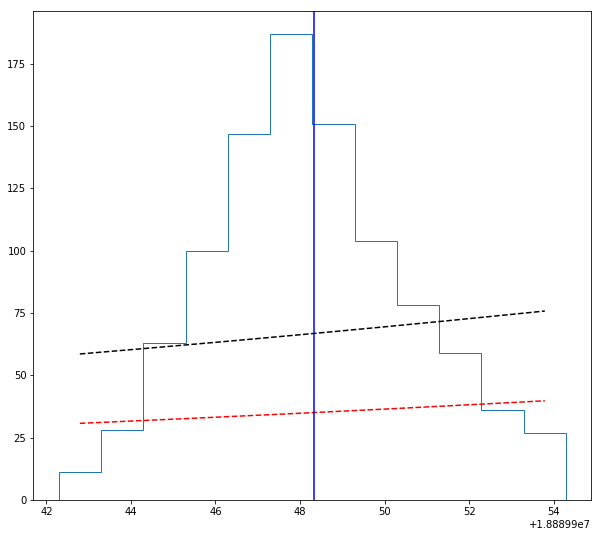

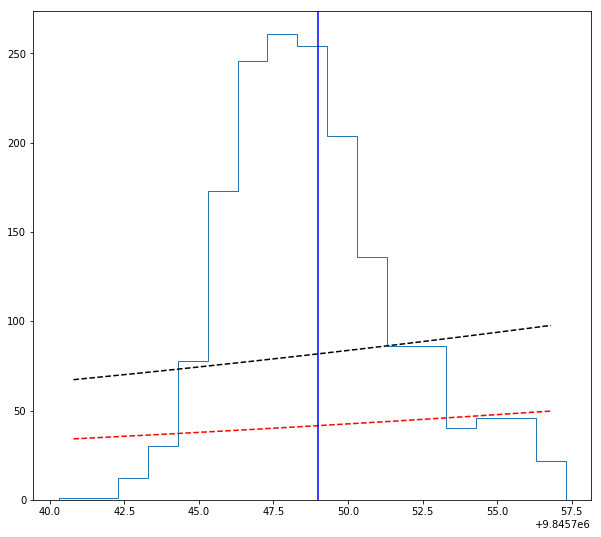

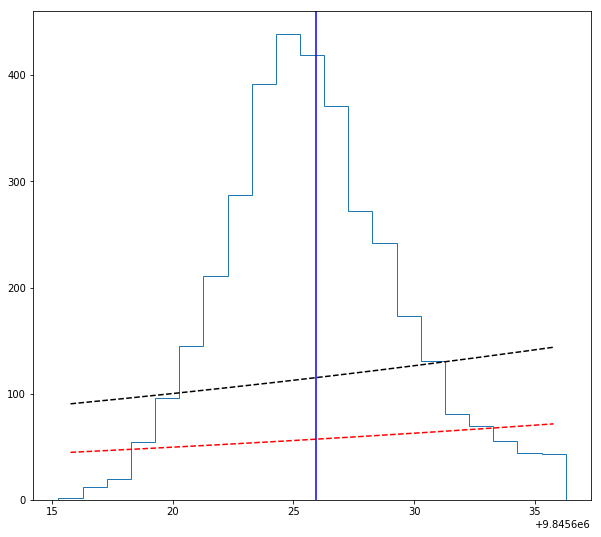

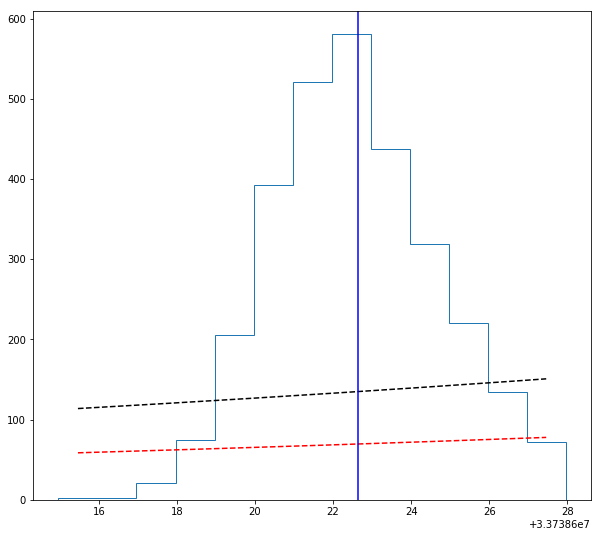

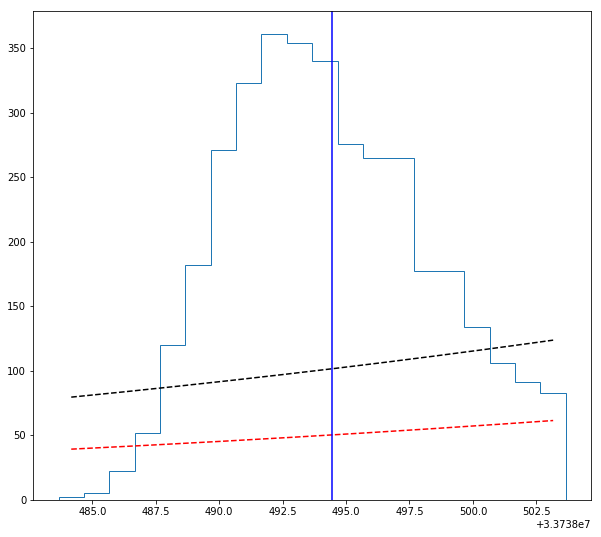

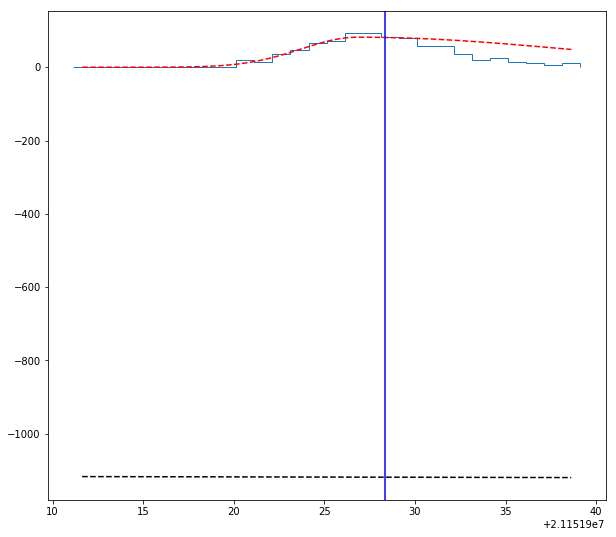

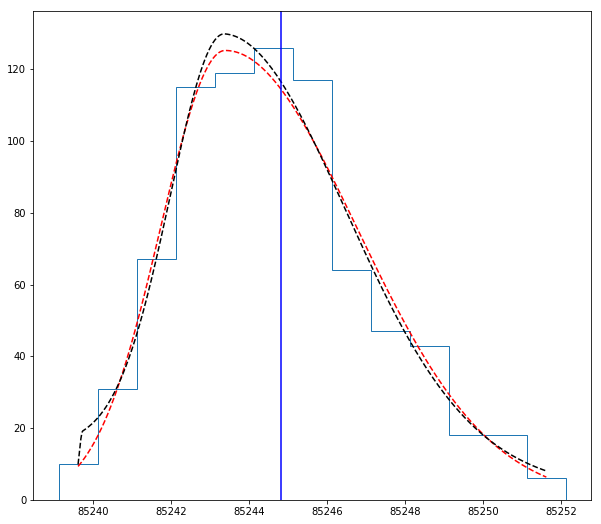

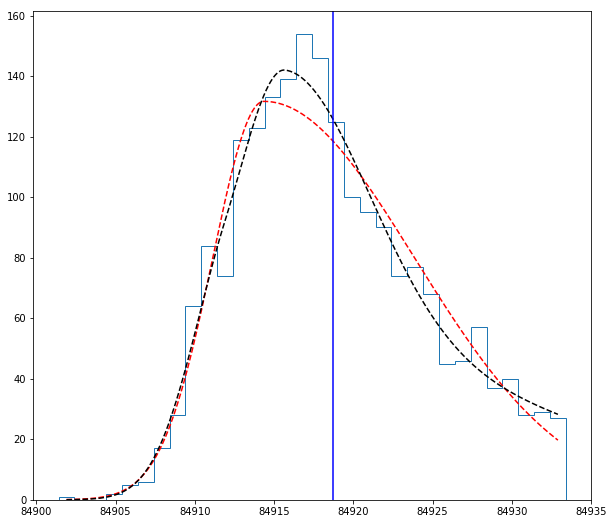

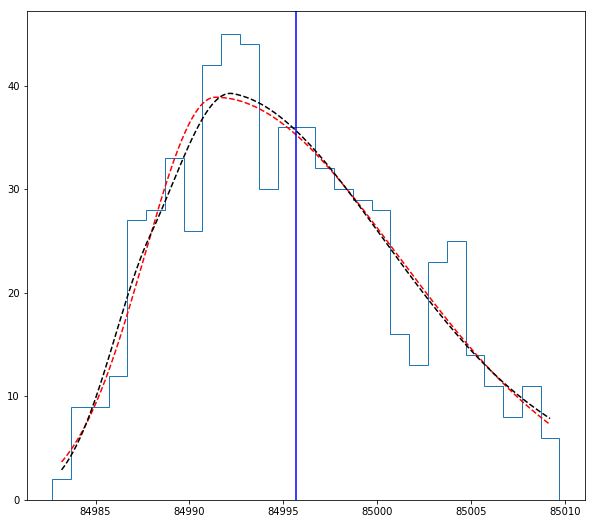

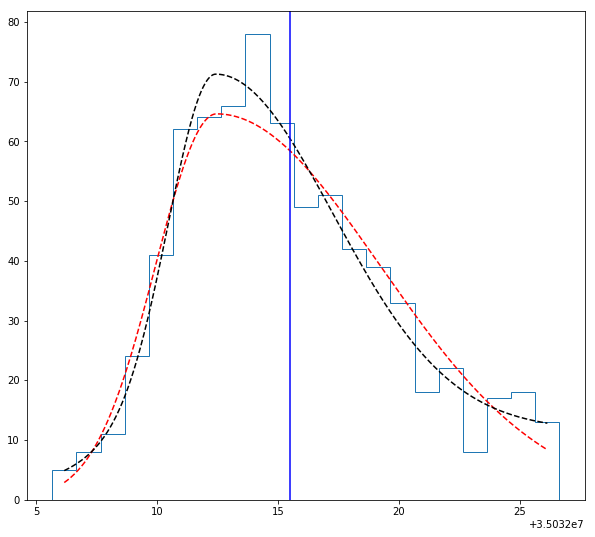

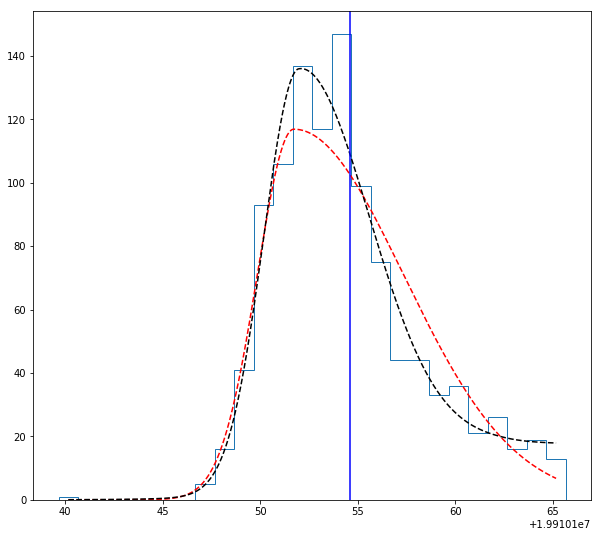

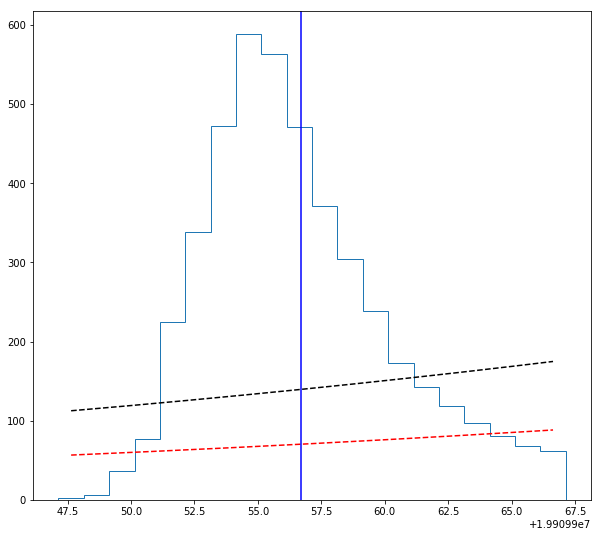

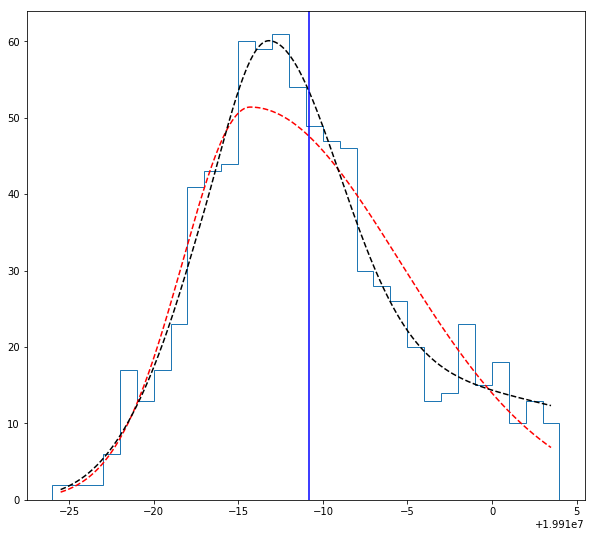

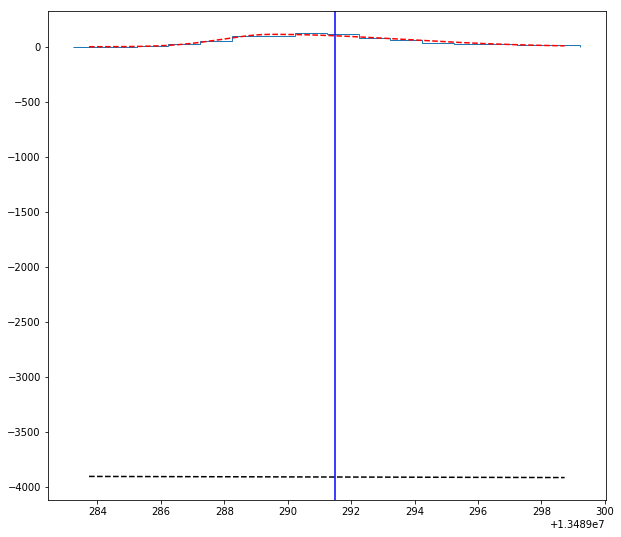

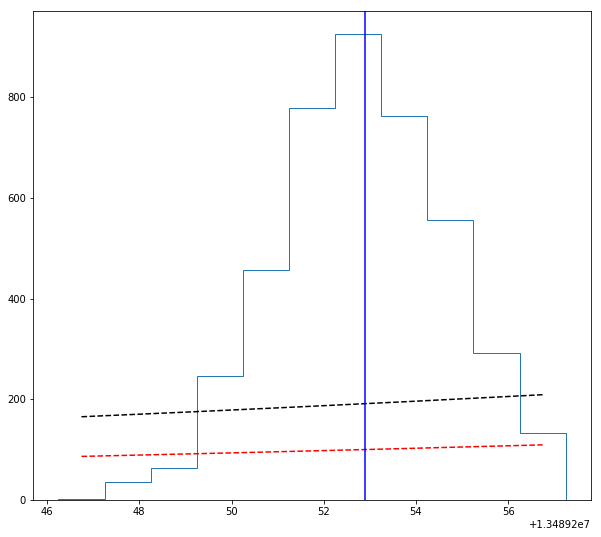

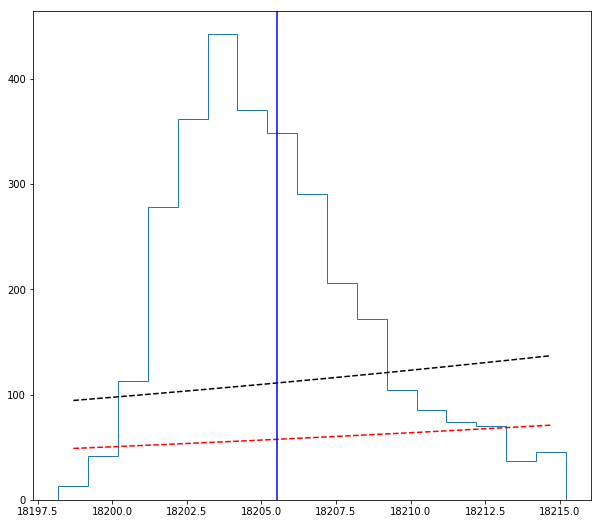

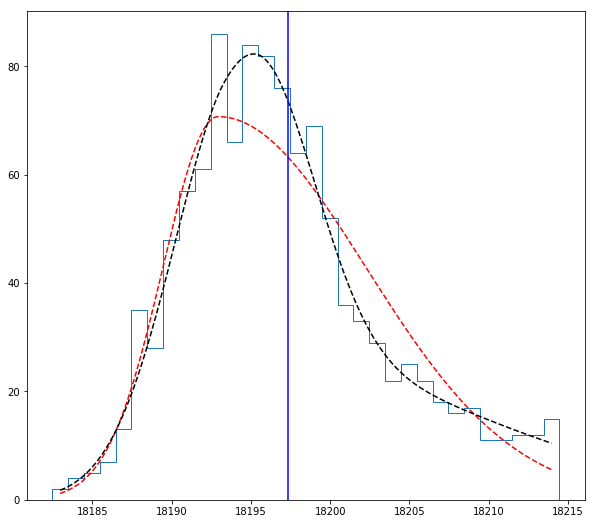

In [3]:
gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
geoMap = geometry.omgeo
print('loaded geometry')

tau_timeDiff = ([])
tau_pVal = ([])

e_timeDiff = ([])
e_pVal = ([])
    
for i in range(90, 150):
    file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')

    f = 1
    for frame in file:
        print('frame num - ', f)
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        #print('Finding OM Positions and time residuals')


        #looping through doms that have physics hits
        for omkey in mcpeMap.keys():
            oKey = geoMap.get(omkey)
            domPos = oKey.position

            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)
        
            #removing doms that have less than 200 mcpe hits
            if len(tot_timeList) > 800 and len(tot_timeList) < 6000: 
                mean_physicsHits = timeList.mean()
                mean_tot = tot_timeList.mean()
            
                select_time = tot_timeList[(tot_timeList > mean_physicsHits-50) & (tot_timeList < mean_physicsHits+50)]
                new_mean = select_time.mean()
            
                bins = np.arange(min(select_time), max(select_time), 1)
                max_hitTimes = select_time[(select_time > (new_mean-35))&(select_time < (new_mean+35))]
            
                z = stats.zscore(max_hitTimes)
                max_hitTimes = max_hitTimes[(z < 1.2)] #using zscore to remove the effect of outliers from the analysis]
                new_mean = max_hitTimes.mean()

                bins = np.arange(min(max_hitTimes), max(max_hitTimes), 1)
                num, bin_edges = np.histogram(max_hitTimes, bins=bins)
                bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
            
                print('LOG LIKELIHOOD')

                nll = lambda *args: log_likelihood_biGauss(*args)
                initial_biGauss = np.array([new_mean-5, 10, 0.1, max(num)])
                #bnds_biGauss = ((min(bin_centers), mean_timeArrival), (0, 20), (0, 2), (0, max(num)), (mean_timeArrival, max(bin_centers)), (0, 20), (0, 2), (0, max(num)))
                print(len(num), len(initial_biGauss), initial_biGauss)
                bnds_biGauss = ((min(bin_centers), max(bin_centers)), (0, 300), (0, 2), (0, max(num)+10))
                soln_biGauss = minimize(log_likelihood_biGauss, initial_biGauss, args=(num, bin_centers), method='Powell', bounds = bnds_biGauss)
            
                nll = lambda *args: log_likelihood_doublePeak(*args)
                initial_doublePeak = np.array([min(bin_centers), 10, 0.1, max(num), new_mean, 10, 0.1, max(num)])
                bnds_doublePeak = ((min(bin_centers), new_mean), (0, 50), (0, 2), (0, max(num)+10), (new_mean, max(bin_centers)), (0, 50), (0, 2), (0, max(num)+10))
                soln_doublePeak = minimize(log_likelihood_doublePeak, initial_doublePeak, args=(num, bin_centers), method='Powell',bounds=bnds_doublePeak)
             
                LR_biGauss = likelihood_ratio_biGauss(bin_centers, num, soln_biGauss.x[0], 
                                             soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
                LR_doublePeak = likelihood_ratio_doublePeak(bin_centers, num, soln_doublePeak.x[0], soln_doublePeak.x[1], 
                                             soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4], 
                                             soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])

                pVal_biGauss = chi2.sf(LR_biGauss, len(num) - 4)
                pVal_doublePeak = chi2.sf(LR_doublePeak, len(num) - 8)
                x = np.linspace(min(bin_centers), max(bin_centers), 1000)
                y_biGauss = biGauss(x, soln_biGauss.x[0], 
                                             soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
                y_doublePeak = double_peak(x, soln_doublePeak.x[0], soln_doublePeak.x[1], 
                                             soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4], 
                                             soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])
            
                plt.figure(figsize=(10,9))
                _ = plt.hist(max_hitTimes, bins=bins, histtype='step')
                plt.plot(x, y_biGauss, '--', c = 'r')
                plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(new_mean, c = 'b')
            
                timeDifference_doublePeak = soln_doublePeak.x[4] - soln_doublePeak.x[0]
                pVal_ratio = pVal_doublePeak/pVal_biGauss
                
                print(timeDifference_doublePeak)
            
                if lepton.type == 11 or lepton.type == -11:
                    tau_timeDiff = np.append(tau_timeDiff, timeDifference_doublePeak)
                    tau_pVal = np.append(tau_pVal, pVal_ratio)
            
                if lepton.type == 15 or lepton.type == -15:
                    e_timeDiff = np.append(e_timeDiff, timeDifference_doublePeak)
                    e_pVal = np.append(e_pVal, pVal_ratio)
                
            
                print('P-VAL CALCULATED')
            
            
        '''
        print(tot_timeList)
        
        bins = np.arange(min(tot_timeList), min(tot_timeList)+41, 1)
        num, bin_edges, _ = plt.hist(tot_timeList, bins=bins, histtype='step')
        plt.title('Tau')
        '''
        
    f = f+1
#print(tot_timeList)

In [4]:
tau_timeDiff, e_timeDiff, tau_pVal, e_pVal

(array([ 5.66064020e+00,  6.89687336e-01,  7.03600140e+00,  8.10870340e+00,
         2.06054193e+00,  5.23239864e+00,  7.34422895e+00,  7.00732576e+00,
         6.04403540e+00, -1.88456943e+02,  6.49670588e+00,  8.55585650e-01,
         1.37267813e+00,  1.04647082e+04,  1.25396818e+01, -3.15214657e-01,
         6.88636463e+00,  7.31190290e+00, -5.59725734e-01,  1.24357721e+00,
         1.25475419e+01,  4.52644040e+00,  6.19915374e+00,  1.03507238e+00,
         9.74266909e-01,  9.27017357e-01,  8.18094316e+00,  1.01816221e+01,
         3.63970894e+00,  3.82895567e+00,  4.43240124e+00,  5.42539105e-01,
        -1.07285176e+01,  9.06172520e+00,  3.95589491e+00,  6.82025939e+00,
         1.96977033e+00]),
 array([ 1.78046894e+00,  4.38233304e+01, -4.89605297e+03,  6.17985404e+00,
         7.52293676e+00,  6.53220229e+00,  1.07617282e+01,  1.83658101e+01,
        -2.56834789e-01,  7.23437385e+00,  1.29713771e+00,  1.03420366e+01,
        -8.66635110e-01,  8.06178154e+00,  5.30138800e+00,  1

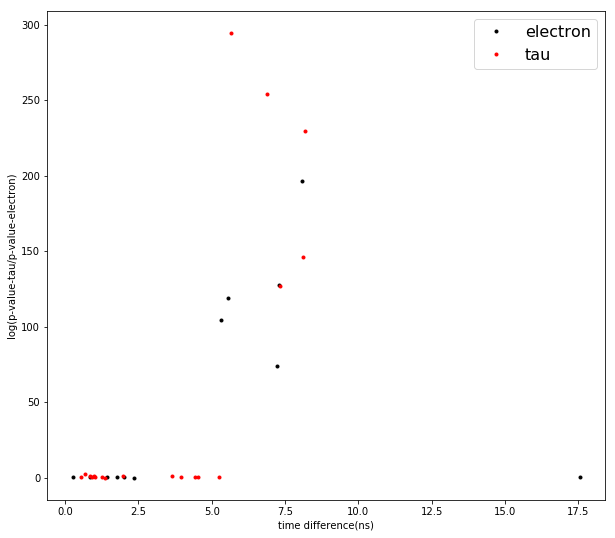

In [5]:
plt.figure(figsize=(10,9))
plt.plot(abs(e_timeDiff), abs(np.log(e_pVal)), '.', c='k', label='electron')
plt.plot(abs(tau_timeDiff[tau_timeDiff >0]), abs(np.log(tau_pVal[tau_timeDiff > 0])), '.', c ='r', label='tau')
plt.legend(fontsize=16)
plt.xlabel('time difference(ns)')
plt.ylabel('log(p-value-tau/p-value-electron)')

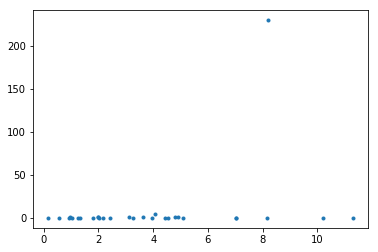

In [30]:
plt.plot(abs(tau_timeDiff[tau_timeDiff > 0]), abs(np.log(tau_pVal[tau_timeDiff > 0])), '.')

In [4]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt

In [10]:
file = dataio.I3File('/data/p-one/akatil/step_3_medium_water/Custom/NuTau_NuE_20Events/step_3_713_medium_water_custom_mDOM.i3.gz')

In [11]:
gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
geoMap = geometry.omgeo
print('loaded geometry')

loaded geometry


In [4]:
maxMCPE_e = 0
maxMCPE_t = 0 

f = 1
for frame in file:
    print('new Frame')
    mctree = frame["I3MCTree"]
    primary = mctree.primaries
    lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)
    #tauDecayProd = dataclasses.I3MCTree.get_daughters(mctree, tau.id)
    #daughterTauPos = tau.pos
    #daughterTauEnergies = tauDecayProd.energy

    mcpeMap = frame['MCPESeriesMap']

    print('Finding OM Positions and time residuals')


    for omkey in mcpeMap.keys():
        oKey = geoMap.get(omkey)
        domPos = oKey.position

        mcpeList = mcpeMap[omkey]
        timeList = [mcpe.time for mcpe in mcpeList]
        timeList = np.array(timeList)
        print(timeList)
        #timeRes = timeList - timeTaken
        if lepton.type == 11 or lepton.type == -11:
            if len(timeList) > maxMCPE_e and len(timeList) < 900:
                #print('-----TIME LIST ------', len(timeList))      #electron
                maxMCPE_e = len(timeList)
                timeArrival_e = timeList
        if lepton.type == 15 or lepton.type == -15:
            if len(timeList) > maxMCPE_t and len(timeList) < 2000:
                #print('-----TIME LIST ------', len(timeList))      #tau
                print('frame - ', f)
                print('tau energy- ', lepton.energy)
                print('OMKEY', omkey)
                maxMCPE_t = len(timeList) 
                timeArrival_t = timeList
    f = f+1

new Frame
Finding OM Positions and time residuals
[650710.43417596]
[650489.25597522]
[650543.52618986]
[650336.47803722]
[650076.02388348]
[649798.87076479]
[649701.61601255 649699.33114608 649691.06481973 649894.78776631
 649749.08006697 649768.25176509 649801.92170496 649698.57813764]
[649625.01254893 650069.47243665 649612.93826623 649618.0803309
 649614.75952528 649621.35642256 649612.43338668]
[649734.72031822 649847.67517472 649599.36848914]
[649593.23595107 649600.26584944 649562.81988817 649560.92300622
 649566.28455018 649571.96921161]
[649647.07234632 649629.74927461 649599.94098961]
[649794.7284206  649672.91131284]
[650511.96406813 649777.82444982 649784.15841327 649774.66859951
 649782.23950889 649773.13015623 649777.70451335 649802.80388549
 649769.38212656 649775.17688596]
[650140.80234936 649967.68166802]
[650174.63992338]
[649782.05242901]
[649562.79511883 649567.12015718 649715.89461682 649682.99136771
 649608.32845903 649615.60840477]
[649568.18511133 649442.1684929

 35425591.60731199 35425646.60477872 35425622.1575656  35425666.52630753]
[35425842.0709763  35426089.97854331 35425755.47973023 35425751.92121662]
[35426240.47917463 35425875.47403206]
[35426077.16191041 35426098.82932021 35426090.08861513 35426095.50919227
 35426597.99489064 35426084.34143071 35426080.34101178 35426078.33375746
 35426106.59224678 35426079.14209044 35426094.29048125 35426087.95591511
 35426106.68982626 35426087.77833556 35426077.86659691 35426204.324637
 35426084.86608893 35426084.55541819 35426080.23788454 35426080.72645777]
[35425994.62323102 35425928.67823255 35425926.20796228 35425926.5313185
 35425933.49295374 35425927.22547731 35425933.2699054  35426046.4678671
 35425930.02727734 35425931.32386116 35425926.72630948 35425927.65292165
 35425935.60615256 35426065.78654298 35425932.23299916 35425928.86828117
 35425929.05823813 35425926.57158232 35425929.43354095 35425951.40675537
 35425926.27280472 35425938.0732859  35425932.32445123 35425929.57409845
 35425929.9288

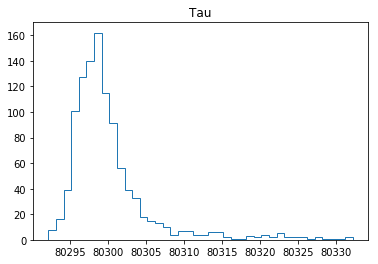

In [5]:
timeArrival = timeArrival_t
bins = np.arange(min(timeArrival), min(timeArrival)+41, 1)
num, bin_edges, _ = plt.hist(timeArrival, bins=bins, histtype='step')
plt.title('Tau')

In [43]:
for r in range(0, len(num)):
    percent = (np.sum(num[:r])/np.sum(num))*100
    if percent >= 95:
        index = r
        break

In [44]:
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
print(bin_centers[index])
newT = timeArrival[timeArrival < bin_centers[index]]
mean_timeArrival = newT.mean()
print(mean_timeArrival)

80312.68332091223
80299.1784335625


In [45]:
bins = np.arange(min(timeArrival), min(timeArrival)+index+1, 1)
num, bin_edges, _ = plt.hist(timeArrival, bins=bins, histtype='step')
plt.axvline(mean_timeArrival, c='r')

In [46]:
import scipy

def gaussian(x, pos, wid, amp):
    y = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    return y

def BiGauss(x, pos, wid, r, amp):
    mask = x < pos
    
    y_all = ([])
    for i in range(0, len(mask)):
    
        if mask[i] == True:
            m = 1
            nm = 0
        else:
            m = 0
            nm = 1
        if r != 0:
            y1 = gaussian(x[i],pos,r*wid/(r+1),amp)*m
            y2 = gaussian(x[i],pos,wid/(r+1),amp)*nm
            y = y1 + y2
        else:
            y = gaussian(x[i],pos,wid)*nm
        
        y_all = np.append(y_all, y)
    return y_all
    
def double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    x1 = x[x <= min(x)+10]
    x2 = x[x > min(x)+10]
    b1 = BiGauss(x, pos1, wid1, r1, amp1)
    b2 = BiGauss(x, pos2, wid2, r2, amp2)
    b = np.append(b1, b2)
    return b1+b2

def log_likelihood(theta, n, x):
    #pos, wid, r, amp = theta
    #pos, wid, amp = theta
    pos1, wid1, r1, amp1, pos2, wid2, r2, amp2 = theta
    #model = gaussian(x, pos, wid, amp)
    #model = BiGauss(x, pos, wid, r, amp)
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    L = np.log(scipy.special.factorial(n)) + model - (n*np.log(model))
    return np.sum(L)
    
'''
def log_likelihood(theta, x, y):
    pos, wid, amp, log_f = theta
    yerr = 0
    model = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
'''

'\ndef log_likelihood(theta, x, y):\n    pos, wid, amp, log_f = theta\n    yerr = 0\n    model = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)\n    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)\n    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))\n'

In [47]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood(*args)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
#initial = np.array([bin_centers[num == max(num)], 5, 0.1, max(num)])
#initial = np.array([bin_centers[num == max(num)], 5, max(num)])
initial = np.array([min(bin_centers), 10, 0.1, max(num), mean_timeArrival, 10, 0.1, max(num)])
bnds = ((min(bin_centers), mean_timeArrival), (0, 20), (0, 2), (0, max(num)), (mean_timeArrival, max(bin_centers)), (0, 20), (0, 2), (0, max(num)))
soln = minimize(log_likelihood, initial, args=(num, bin_centers), method='Powell',bounds=bnds)

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


In [48]:
x = np.linspace(min(bin_centers), max(bin_centers), 1000)
#y = gaussian(x, soln.x[0], soln.x[1], soln.x[2])
#y = BiGauss(x, soln.x[0], soln.x[1], soln.x[2], soln.x[3])
y = double_peak(x, soln.x[0], soln.x[1], soln.x[2], soln.x[3], soln.x[4], soln.x[5], soln.x[6], soln.x[7])

In [49]:
soln

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-6.74485676e-03, -3.45937129e-02,  2.54960860e-03,
         2.87595188e-01, -2.61247696e-02,  2.64608434e-03,
        -4.15344128e-03, -3.19018059e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 2.43829718e-01, -4.47276897e-01,  5.95875142e-02,
        -1.54913422e+00,  3.58114097e-02,  2.02709996e-01,
        -9.75245732e-03, -2.29166638e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,

<IPython.core.display.Javascript object>


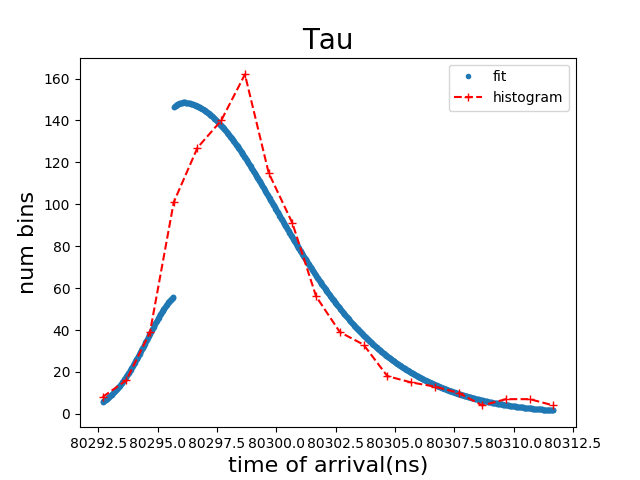

In [50]:
%matplotlib notebook
plt.plot(x, y, '.', label = 'fit')
plt.plot(bin_centers, num, '--+', color = 'r', label = 'histogram')
plt.ylabel('num bins', fontsize=16)
plt.xlabel('time of arrival(ns)', fontsize=16)
plt.title('Tau', fontsize = 20)
plt.legend()

In [19]:
def likelihood_ratio(x, n, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    val = model - n + (n*np.log(n/model))
    print(val)
    return np.sum(val)

In [19]:
def likelihood_ratio(x, n, pos, wid, r, amp):
    model = BiGauss(x, pos, wid, r, amp)
    val = model - n + (n*np.log(n/model))
    print(val)
    return np.sum(val)


In [20]:
LR = likelihood_ratio(bin_centers, num, soln.x[0], soln.x[1], soln.x[2], soln.x[3])

[ 0.34935102  0.76400034  0.34758581  1.62382014  2.54014802  1.63937989
  3.41642489  3.45046894  1.84332448  8.8324193   0.4749362   5.03281067
 10.68461888  6.8824253   7.71546532 10.28662236 12.02127603 37.46424694]


In [20]:
LR = likelihood_ratio(bin_centers, num, soln.x[0], soln.x[1], soln.x[2], soln.x[3], soln.x[4], soln.x[5], soln.x[6], soln.x[7])

[1.04452306e-01 7.52591002e-01 7.57488341e-01 1.29168641e-03
 3.94882552e-01 2.58796421e-01 6.84784277e-02 2.04152168e-01
 3.95948239e-03 2.43614323e+00 6.01527374e-01 1.21516293e-01
 6.75255987e-01 5.85344942e-02 3.58249197e-01 4.97706357e-01
 7.84150842e-01 3.21053836e-01 4.76031969e-02 4.20141532e-01]


In [21]:
from scipy.stats.distributions import chi2

p = chi2.sf(LR, 8)

In [22]:
p

0.3535556811151988

In [358]:
popt, pcov = scipy.optimize.curve_fit(gaussian, xdata=bin_centers, ydata=num,
                                      p0 = (41194018.90347786+10, 10, 200), absolute_sigma=True)

In [359]:
bin_centers[num == max(num)]

array([41194018.90347786])

In [360]:
popt

array([4.11940192e+07, 8.36489509e+00, 6.16024090e+01])

In [212]:
x1 = np.linspace(min(bin_centers)-10, max(bin_centers)+10, 1000)
y1 = gaussian(x, popt[0], popt[1], popt[2])

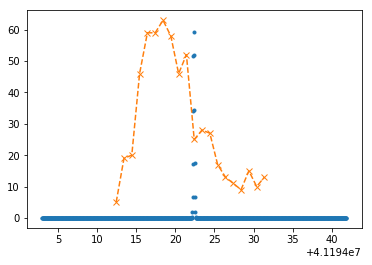

In [213]:
plt.plot(x1, y1, '.')
plt.plot(bin_edges[:-1], num, '--x')

In [39]:
sc.signal.find_peaks_cwt?

Object `sc.signal.find_peaks_cwt` not found.


In [18]:
timeArrival_t[173]

80313.08465242606

In [38]:
import scipy as sc

In [ ]:
sc.sign